## 1 - Import libraries

In [11]:
import numpy as np
import pandas as pd
import pickle

from sklearn.linear_model import ElasticNet, HuberRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import LeaveOneGroupOut
import random
from scipy.stats import loguniform
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, pearsonr
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor


## 2- Load Data

Load the data from `multiomics_data.pickle` using `pickle`. You will get a [pandas](https://pandas.pydata.org/docs/user_guide/10min.html) DataFrame containing data. The data contains several meta attributes as well as the different modalities.

Meta attributes include:

* `Sex`: sex of the baby
* `timepoint`: 1-3 correspond to the three trimesters, 4 corresponds to postpartum
* `gestational_age`: time of sampling

Modalites are:
    
* `cellfree_rna`
* `metabolomics`
* `microbiome`
* `plasma_luminex`
* `serum_luminex`
* `immune_system`
* `plasma_somalogic`

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

with open("/content/drive/MyDrive/multiomics/multiomics_data.pickle", "rb") as file:
    data_multiomics = pickle.load(file)

data_multiomics

Training/Validation Gates ID       MRN Study Subject ID Number     Sex  \
                                                                            
0                    T  PTLG002  16661779                   10565    Male   
1                    T  PTLG002  16661779                   10565    Male   
2                    T  PTLG002  16661779                   10565    Male   
3                    T  PTLG002  16661779                   10565    Male   
4                    T  PTLG004  23587868                   10603  Female   
..                 ...      ...       ...                     ...     ...   
63                   T  PTLG029  40310948                   10631  Female   
64                   T  PTLG016  20328266                   30101    Male   
65                   T  PTLG016  20328266                   30101    Male   
66                   T  PTLG016  20328266                   30101    Male   
67                   T  PTLG016  20328266                   30101    Male   

   sex_bin timepoint gestational_age cellfree_rna                ...  \
                                        0_C2orf76      1_ACTL10  ...   
0        1         1              11     0.312437 -1.892930e-16  ...   
1        1         2              18     0.312437 -1.892930e-16  ...   
2        1         3              32     0.312437 -1.892930e-16  ...   
3        1         4              45     0.312437 -1.892930e-16  ...   
4        0         1              11     5.204209  1.734736e+00  ...   
..     ...       ...             ...          ...           ...  ...   
63       0         4              46     0.312437 -1.892930e-16  ...   
64       1         1              10     0.000000  0.000000e+00  ...   
65       1         2              19     0.000000  0.000000e+00  ...   
66       1         3              31     0.000000  0.000000e+00  ...   
67       1         4              47     0.000000  0.000000e+00  ...   

   plasma_somalogic                                               \
        1290_UBE2G2 1291_TAGLN2 1292_ATP5O 1293_POMC 1294_CRYZL1   
0            4804.4      2233.0     3610.9     715.8       151.4   
1            4086.0      2160.5     2260.4     825.2       161.0   
2            4328.0      1818.4     2445.2    1241.8       194.6   
3            3442.4      2661.4     3879.2     703.6       153.7   
4            4261.9      1804.6     1470.6     526.8       163.0   
..              ...         ...        ...       ...         ...   
63           4391.7      2458.9     3245.9     582.9       243.3   
64           3622.7      2625.1     3154.4     414.9       164.2   
65           5090.5      2206.1     2860.7     706.7       176.6   
66           5043.6      1894.1     1905.7     938.7       211.6   
67           4296.6      2278.2     2777.4     668.0       165.0   

                                                             
   1295_SERPINF1 1296_CTSF 1297_FTCD 1298_USP25 1299_PLXNB2  
0        37885.8    1479.1    3261.8      561.3      3227.0  
1        41821.5    1465.1    1839.8      597.8      3366.0  
2        45526.1    1428.3    3057.2      625.7      8703.7  
3        36862.5    1063.6    7339.7      593.2      2918.9  
4        38938.3    1170.1    1036.8      552.8      3457.1  
..           ...       ...       ...        ...         ...  
63       33475.3    1322.6   19361.7     1750.4      3012.4  
64       40142.8    1417.0    2424.4      725.2      3066.3  
65       38453.5    1811.2    1737.5      737.2      3340.8  
66       47249.5    2521.8    1026.5      667.2      5981.0  
67       45130.9    1781.2    5904.1      697.3      3246.2  

[68 rows x 61274 columns]

In [4]:
def extract_omic_data(data, omic):
    """
    Extracts and standardizes omic data while retaining associated metadata.

    Parameters:
    - data (pd.DataFrame): A pandas DataFrame containing both omic and metadata columns.
    - omic (list): A list of column names representing the omic data to be extracted and standardized.

    Returns:
    - pd.DataFrame: A DataFrame containing standardized omic data with associated metadata.

    This function takes a pandas DataFrame 'data' that includes both omic data and metadata columns,
    and a list 'omic' specifying the omic features to be extracted and standardized. It performs the
    following steps:

    1. Extracts metadata columns 'Study Subject ID Number', 'gestational_age', and 'timepoint'.
    2. Assigns unique 'Sample_Number' as an index to the metadata DataFrame.
    3. Standardizes the selected omic data using StandardScaler.
    4. Combines the standardized omic data with metadata based on the 'Sample_Number' column.
    5. Removes rows with 'timepoint' equal to 4, representing the postpartum trimester.

    Example Usage:
    >>> data = pd.read_csv('data.csv')
    >>> omic_features = ['feature1', 'feature2', 'feature3']
    >>> extracted_data = extract_omic_data(data, omic_features)

    Note:
    - Make sure 'data' includes columns 'Study Subject ID Number', 'gestational_age', 'timepoint',
      and the omic features specified in 'omic'.
    - The 'timepoint' column is used to filter out rows corresponding to the postpartum trimester.
    - Standardization ensures that omic data is mean-centered and scaled to unit variance.
    """
    Meta_attributes = data[["Study Subject ID Number", "gestational_age", "timepoint"]]
    Meta_attributes['Sample_Number'] = range(0, len(Meta_attributes))
    Meta_attributes = Meta_attributes.set_index("Sample_Number")
    Meta_attributes.columns = Meta_attributes.columns.droplevel(1)
    Meta_attributes.columns = ['StudySubjectIDNumber', 'gestational_age', 'timepoint']

    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data[omic])
    omic_df = pd.DataFrame(standardized_data, columns=data[omic].columns)
    omic_df['Sample_Number'] = range(0, len(omic_df))
    omic_df = omic_df.set_index("Sample_Number")

    merged_df = pd.merge(omic_df, Meta_attributes, on="Sample_Number", how="inner")
    merged_df.columns = merged_df.columns.get_level_values(0)
    # Remove the postpartum trimester
    merged_df = merged_df[merged_df['timepoint'] != 4]
    return merged_df


In [5]:
#dataset names
#'cellfree_rna','metabolomics','microbiome','plasma_luminex','serum_luminex','immune_system','plasma_somalogic'
omic_data =extract_omic_data(data_multiomics,"metabolomics")
omic_data

<ipython-input-4-f6c5e03abe5a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Meta_attributes['Sample_Number'] = range(0, len(Meta_attributes))


,0,1,2,3,4,5,6,7,8,9,...,3478,3479,3480,3481,3482,3483,3484,StudySubjectIDNumber,gestational_age,timepoint
Sample_Number,,,,,,,,,,,,,,,,,,,,,
0,1.147382,0.923555,0.904579,0.356172,0.484367,-0.932818,-0.745888,0.122847,-0.448629,0.268737,...,0.653157,-0.820466,0.612101,0.639483,-0.321457,0.786032,0.864434,10565,11,1
1,0.552521,0.391318,0.674923,0.477394,0.891511,-0.404315,0.142361,0.294084,-0.640711,0.619167,...,1.028022,-0.297699,0.985264,0.994132,0.120606,1.030780,0.982849,10565,18,2
2,-0.207755,-0.729076,-0.751619,-0.767171,-0.157967,-0.263208,-0.310545,-0.753752,-1.048240,-0.215011,...,-0.071192,-1.101975,-0.230235,-0.178436,4.096482,-0.171626,-0.265582,10565,32,3
4,1.819907,1.446893,1.391722,0.930924,1.109644,-0.103985,1.059456,0.621768,-0.154881,0.914188,...,1.183428,0.010212,1.211894,1.217150,0.224838,1.321368,1.432160,10603,11,1
5,0.143488,0.105294,-0.334660,-0.793433,-1.116596,-1.076516,0.481122,-0.824623,0.499277,-0.868309,...,-1.124217,0.300621,-1.099745,-1.103072,-0.023846,-1.051936,-0.985959,10603,18,2
6,0.878057,-0.052351,-0.460849,-0.666914,-0.637095,0.079641,1.320562,-0.648481,-0.016179,-0.559557,...,-0.772725,0.347577,-0.709082,-0.757985,-0.668044,-0.634949,-0.490390,10603,27,3
8,1.026569,1.144349,0.869685,0.876603,0.943433,-0.373124,-0.431484,0.957920,-0.084287,0.636180,...,1.074992,-0.130254,1.085962,1.082327,1.164021,1.237917,1.371206,10604,11,1
9,1.724067,1.266958,1.054160,0.986967,1.126394,-0.142702,-0.411888,1.078241,0.252241,0.729517,...,1.229740,-0.033018,1.235662,1.239063,0.322048,1.383442,1.563180,10604,15,2
10,0.254769,-0.630407,-0.663979,-0.765478,-0.109263,0.128638,1.213978,-0.784242,-0.917078,0.020224,...,-0.081494,-0.557313,-0.235490,-0.172808,-0.559510,-0.054405,0.099178,10604,25,3


## 3. EDA

### 3.1 Number of features in each dataset

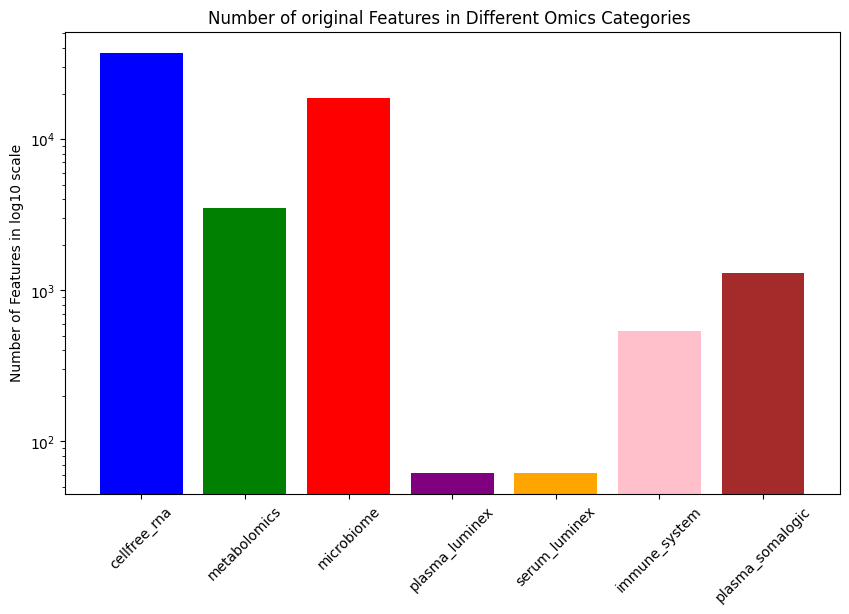

In [7]:
import matplotlib.pyplot as plt

# List of omics data types
omics = ['cellfree_rna', 'metabolomics', 'microbiome', 'plasma_luminex', 'serum_luminex', 'immune_system', 'plasma_somalogic']

# Number of features for each omics data type
nb_features = [37275, 3485, 18548, 62, 62, 534, 1300]

# Colors for the bars in the bar plot
colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown']

# Create a bar plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Create the bar chart with omics as x-axis labels and nb_features as bar heights
plt.bar(omics, nb_features, color=colors)

# Label the y-axis
plt.ylabel('Number of Features in log10 scale')

# Set the y-axis to a logarithmic scale for better visualization
plt.yscale('log')
plt.title('Number of original Features in Different Omics Categories ')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


### 3.2 Check the independence between features and feature selection

In [8]:
columnslist=omic_data.columns.tolist()

#Remove the last 3 meta data columns from columnslist list.
columnslist.pop(-1)
columnslist.pop(-1)
columnslist.pop(-1)


'StudySubjectIDNumber'

In [9]:

def calculate_correlations_and_select_important_features(omic_data, columnslist, alpha=0.01):
    """
    Calculate Spearman and Pearson correlations and select significant features.

    Parameters:
    - omic_data (pd.DataFrame): DataFrame containing omics data.
    - columnslist (list): List of column names of features to correlate.
    - alpha (float, optional): Significance level for feature selection. Defaults to 0.05.

    Returns:
    - list: List of significant features based on both Spearman and Pearson correlations.

    This function calculates Spearman and Pearson correlation coefficients and p-values for each feature
    in 'columnslist' with respect to 'gestational_age' in the 'omic_data' DataFrame. It then selects
    features with adjusted p-values below the significance level 'alpha' for both methods.

    Example Usage:
    >>> selected_features = calculate_correlations_and_select_features(omic_data, columnslist)
    >>> print(len(selected_features), "significant features selected.")
    """
    datadf = omic_data[columnslist].copy()

    # Calculate Spearman and Pearson correlation coefficients and p-values for each feature
    spearmanr_correlations_r = []
    spearmanr_correlations_p = []
    pearsonr_correlations_r = []
    pearsonr_correlations_p = []

    for i in range(datadf.shape[1]):
        spearman_corr, spearman_p = spearmanr(datadf.iloc[:, i], omic_data['gestational_age'])
        pearson_corr, pearson_p = pearsonr(datadf.iloc[:, i], omic_data['gestational_age'])
        spearmanr_correlations_r.append(spearman_corr)
        spearmanr_correlations_p.append(spearman_p)
        pearsonr_correlations_r.append(pearson_corr)
        pearsonr_correlations_p.append(pearson_p)

    # Create DataFrames with Spearman and Pearson correlations and p-values
    df1 = pd.DataFrame({
        "Spearman Correlation rho": spearmanr_correlations_r,
        "Spearman p-value": spearmanr_correlations_p,
    }, index=[f"{i}" for i in range(datadf.shape[1])])

    df2 = pd.DataFrame({
        "Pearson Correlation rho": pearsonr_correlations_r,
        "Pearson p-value": pearsonr_correlations_p,
    }, index=[f"{i}" for i in range(datadf.shape[1])])

    # Select features with adjusted p-values below the significance level for both methods
    spearmanr_significant_features = list(df1[df1['Spearman p-value'] <= alpha].index)
    pearsonr_significant_features = list(df2[df2['Pearson p-value'] <= alpha].index)

    # Combine the significant features from both methods
    final_selected_features = list(set(spearmanr_significant_features + pearsonr_significant_features))

    return final_selected_features



In [12]:
important_featues = calculate_correlations_and_select_important_features(omic_data,columnslist)

In [13]:


def find_highly_correlated_features(omic_data, important_features, threshold=0.9):
    """
    Find highly correlated features in omics data.

    Parameters:
    - omic_data (pd.DataFrame): DataFrame containing omics data.
    - final_selected_features (list): List of selected features to analyze for correlation.
    - threshold (float, optional): Correlation threshold to consider features as highly correlated.
      Defaults to 0.9.

    Returns:
    - list: List of highly correlated features .

    This function calculates the correlation matrix for the selected features in 'omic_data' and
    identifies pairs of features that have a correlation coefficient greater than or equal to the
    specified 'threshold'.

    Example Usage:
    >>> correlated_pairs = find_highly_correlated_features(omic_data, final_selected_features)
    >>> print(len(correlated_pairs), "highly correlated feature pairs found.")
    """
    correlation_matrix = omic_data[important_features].corr()
    highly_correlated_pairs = []

    # Iterate through the correlation matrix
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) >= threshold:
                highly_correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

    selected_features = []
    if len(highly_correlated_pairs) > 0:
        print("Highly correlated feature pairs:")
        for pair in highly_correlated_pairs:
            print(pair)
            selected_features.append(pair[0])
    else:
        print("No highly correlated features found.")

    selected_features = list(set(selected_features))
    return selected_features



In [14]:
high_correlated_features=find_highly_correlated_features(omic_data,important_featues)

Streaming output truncated to the last 5000 lines.
('353', '2599')
('353', '2400')
('353', '441')
('353', '1411')
('353', '3444')
('353', '522')
('353', '1545')
('353', '2533')
('353', '2595')
('353', '357')
('353', '2576')
('353', '3175')
('353', '2628')
('353', '3394')
('353', '3162')
('353', '947')
('353', '2668')
('353', '3265')
('353', '284')
('353', '2568')
('353', '3299')
('353', '1577')
('353', '2394')
('353', '1439')
('353', '2637')
('353', '3013')
('353', '666')
('353', '1195')
('353', '3119')
('353', '2643')
('353', '665')
('353', '382')
('353', '1045')
('353', '433')
('353', '2775')
('353', '3248')
('353', '2047')
('353', '1488')
('353', '400')
('353', '596')
('353', '292')
('353', '3360')
('353', '2583')
('353', '70')
('353', '286')
('353', '869')
('353', '777')
('353', '1048')
('353', '3184')
('353', '1448')
('353', '1359')
('353', '1354')
('353', '2706')
('353', '1140')
('353', '465')
('353', '306')
('353', '377')
('353', '3135')
('353', '1440')
('353', '1409')
('353', '

In [15]:
set1 = set(important_featues)
set2 = set(high_correlated_features)
final_features = list(set1 - set2)
final_features.append('gestational_age')
final_features.append('StudySubjectIDNumber')

In [16]:
len(final_features)

145

### 3.3 Number of features after Feature reduction step

<ipython-input-17-ebceb917c6d2>:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 38000)


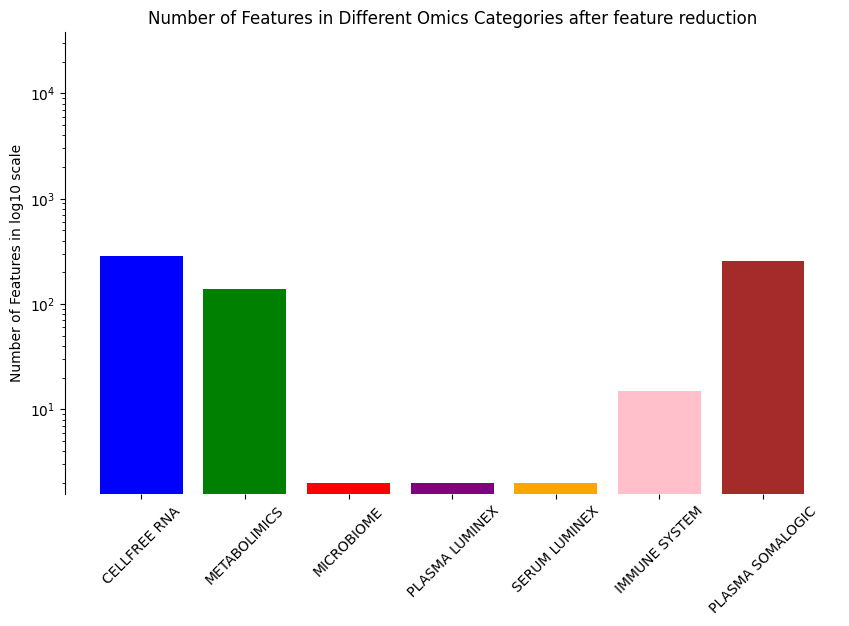

In [17]:
import matplotlib.pyplot as plt

omics = ['CELLFREE RNA', 'METABOLIMICS', 'MICROBIOME', ' PLASMA LUMINEX', 'SERUM LUMINEX', 'IMMUNE SYSTEM', 'PLASMA SOMALOGIC']
nb_features = [288,139,2,2,2,15,258]
colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown']

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(omics, nb_features, color=colors)
# plt.xlabel('Omics')
plt.ylabel('Number of Features in log10 scale')
plt.title('Number of Features in Different Omics Categories after feature reduction')
plt.yscale('log')
plt.ylim(0, 38000)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.show()


In [18]:
dataset = omic_data[final_features].copy()
dataset

,378,3298,1567,3264,1487,73,349,2544,1205,2925,...,3072,1952,3282,2563,1764,2581,1063,2404,gestational_age,StudySubjectIDNumber
Sample_Number,,,,,,,,,,,,,,,,,,,,,
0,-0.053977,-0.201919,1.332191,-0.144995,1.681085,-0.697056,-0.208385,-0.226633,0.375986,-0.524006,...,-0.582801,-2.170933,1.462527,-0.783513,2.351593,0.037181,0.530077,0.449785,11,10565
1,-0.182324,0.393791,-0.262127,0.048755,-0.117487,-0.541537,0.414917,0.113546,-0.043649,0.033120,...,-0.332038,-0.092792,0.133270,0.202178,3.778700,0.377473,0.701331,0.501605,18,10565
2,-0.597432,4.722310,-0.245687,-0.786699,-0.436694,-1.208441,-0.750768,1.984807,5.921946,-0.247189,...,0.495456,0.388353,-0.174448,-1.014696,-0.016666,-0.637904,-0.429692,-0.147008,32,10565
4,-0.121426,-0.464994,0.387782,-0.234794,0.748829,0.330464,-0.307486,-0.154633,0.232893,-0.373794,...,0.064758,-0.667977,0.302029,-0.498352,0.652007,0.347258,0.851083,0.726278,11,10603
5,-0.069423,-0.295686,0.582763,-0.265369,0.763114,-0.377114,0.575914,-0.246882,-0.931458,-0.351282,...,0.070959,1.108423,-0.488814,-0.532468,-0.584003,-0.952937,-0.863475,-1.404345,18,10603
6,-1.309723,0.628867,-0.355939,-1.374031,-1.272378,-0.360392,-0.780560,0.929381,0.549435,2.044260,...,0.729154,2.026420,-1.328964,-1.305905,-0.455987,-1.465246,-0.772221,-1.216988,27,10603
8,0.188284,-0.242465,0.689256,-0.046370,1.307578,0.282577,0.204460,0.033128,0.056972,-0.203194,...,-0.204932,-0.148928,0.022656,0.714634,0.552386,0.710458,0.767324,0.578922,11,10604
9,0.027758,-0.223557,-0.250243,-0.473387,0.212387,0.366516,-0.340826,0.309533,0.120595,-0.350466,...,0.240295,-0.315810,0.594646,-0.183669,0.709124,0.373107,1.073548,0.856531,15,10604
10,-1.404742,1.827991,-1.401094,-1.359050,-0.931469,-1.123257,-1.234609,1.822506,-0.001264,1.022671,...,1.439060,0.487435,-0.887450,-0.422858,-0.038757,-0.956545,-0.498621,-0.361282,25,10604


## 3. Train Models

In [ ]:


# Prepare  X (features) and y (target) data
X = dataset.drop(columns=['gestational_age', 'StudySubjectIDNumber'])
target=dataset['gestational_age']

subject_ids = dataset['StudySubjectIDNumber']

en_cv_model = ElasticNet(alpha=0.39225424004219034,l1_ratio=0.001121512311088321)

logo = LeaveOneGroupOut()
# Perform one-layer cross-validation for predictions
predictions = np.zeros_like(target, dtype=float)

train_spearman_coefficients = []
train_spearman_pvalues = []

val_spearman_coefficients = []
val_spearman_pvalues = []

train_true_values = []
train_predicted_values = []

test_true_values = []
test_predicted_values = []

means_test=[]
means_train=[]
for train_idx, test_idx in logo.split(X, target, groups=subject_ids):  # Assuming you have a predefined cross-validation splitter
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

    # Fit the ElasticNetCV model on the training data to optimize hyperparameters
    en_cv_model.fit(X_train, y_train)

    # Use the trained model to make predictions on the test fold
    # fold_predictions = en_cv_model.predict(X_test)
    y_train_pred = en_cv_model.predict(X_train)
    y_test_pred = en_cv_model.predict(X_test)

    train_true_values.extend(y_train)
    train_predicted_values.extend(y_train_pred)
    test_true_values.extend(y_test)
    test_predicted_values.extend(y_test_pred)

    train_mean=mean_squared_error(y_train, y_train_pred)
    means_train.append(train_mean)

    test_mean=mean_squared_error(y_test, y_test_pred)
    means_test.append(test_mean)

# Calculate the mean squared error
train_mse = mean_squared_error(train_true_values, train_predicted_values)
train_mae = mean_absolute_error(train_true_values, train_predicted_values)
print(f"Train Mean Squared Error: {train_mse}")
print(f"Train Mean absolute Error: {train_mae}")

test_mse = mean_squared_error(test_true_values, test_predicted_values)
test_mae = mean_absolute_error(test_true_values, test_predicted_values)
print(f"Test Mean Squared Error: {test_mse}")
print(f"Test Mean absolute Error: {test_mae}")

In [21]:


def train_and_test_model(model, hyperparameter_names, hyperparameter_values, data):
    """
    Train a given model, perform one-layer cross-validation, and calculate train and test MSE losses.

    Parameters:
    - model: The machine learning model to train and test.
    - hyperparameter_names (list): List of hyperparameter names ('alpha' or 'l1_ratio').
    - hyperparameter_values (list): List of hyperparameter values to use.
    - data (pd.DataFrame): DataFrame containing features and target.

    Returns:
    - list: List of train Mean Squared Error (MSE) losses.
    - list: List of test Mean Squared Error (MSE) losses.

    This function takes a machine learning 'model', lists of hyperparameter names and values,
    and a DataFrame 'data' containing features and target ('gestational_age'). It performs
    one-layer cross-validation for each hyperparameter configuration and returns lists of train
    and test MSE losses for each configuration.

    Example Usage:
    >>> from sklearn.linear_model import ElasticNet
    >>> hyperparameter_names = ['alpha', 'l1_ratio']
    >>> hyperparameter_values = [0.39225424004219034, 0.001121512311088321]
    >>> en_model = ElasticNet()
    >>> train_losses, test_losses = train_and_test_model(en_model, hyperparameter_names, hyperparameter_values, dataset)
    >>> print("Train MSE Losses:", train_losses)
    >>> print("Test MSE Losses:", test_losses)
    """
    X = data.drop(columns=['gestational_age', 'StudySubjectIDNumber'])
    target = data['gestational_age']
    subject_ids = data['StudySubjectIDNumber']


    for i, name in enumerate(hyperparameter_names):
        value = hyperparameter_values[i]

        model.set_params(**{name: value})  # Set hyperparameter for the model

        logo = LeaveOneGroupOut()
        train_true_values = []
        train_predicted_values = []
        test_true_values = []
        test_predicted_values = []

        for train_idx, test_idx in logo.split(X, target, groups=subject_ids):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            train_true_values.extend(y_train)
            train_predicted_values.extend(y_train_pred)
            test_true_values.extend(y_test)
            test_predicted_values.extend(y_test_pred)

    train_mse_value = mean_squared_error(train_true_values, train_predicted_values)
    test_mse_value = mean_squared_error(test_true_values, test_predicted_values)

    return train_mse_value, test_mse_value

# Example Usage:
# from sklearn.linear_model import ElasticNet
# hyperparameter_names = ['alpha', 'l1_ratio']
# hyperparameter_values = [0.39225424004219034, 0.001121512311088321]
# en_model = ElasticNet()
# train_losses, test_losses = train_and_test_model(en_model, hyperparameter_names, hyperparameter_values, dataset)
# print("Train MSE Losses:", train_losses)
# print("Test MSE Losses:", test_losses)


In [23]:
hyperparameter_names = ['alpha', 'l1_ratio']
hyperparameter_values = [2.3079689168500357, 9.076053330889718e-05]
en_model = ElasticNet()
train_losses, test_losses = train_and_test_model(en_model, hyperparameter_names, hyperparameter_values, dataset)
print("Train MSE Losses:", train_losses)
print("Test MSE Losses:", test_losses)


Train MSE Losses: 4.657464591426104
Test MSE Losses: 10.617869175816516


Random Search to find the best hyperparameters

In [33]:
# Drop columns 'gestational_age' and 'StudySubjectIDNumber' from dataset
X = dataset.drop(columns=['gestational_age', 'StudySubjectIDNumber'])
# Extract 'gestational_age' as the target variable
target = dataset['gestational_age']
# Extract 'StudySubjectIDNumber' as subject IDs
subject_ids = dataset['StudySubjectIDNumber']

# Initialize variables to track the best hyperparameters and metrics
best_alpha = None
best_diff = float('inf')
best_lr = None
best_mse = float('inf')
best_n_estimators = None
best_alpha = None
best_l1_ratio = None
best_c = None
best_epsilon = None

# Loop for 500 iterations to find the best model hyperparameters
for i in range(500):
    print("iteration", i)

    # lr=loguniform.rvs(1e-5,1e0,size=1)[0]
    # n_estimators=random.randint(1, 1000)
    alpha=loguniform.rvs(1e-5,1e3,size=1)[0]
    l1_ratio=loguniform.rvs(1e-6,1e0,size=1)[0]
    # learning_rate=loguniform.rvs(1e-5,1e0,size=1)[0]
    # n_estimators=random.randint(1, 1000)
    # c=loguniform.rvs(1e-5,1e3,size=1)[0]
    # epsilon=loguniform.rvs(1e0,1e3,size=1)[0]

    # model=xgb.XGBRegressor(learning_rate=learning_rate, n_estimators=n_estimators)
    model = ElasticNet(alpha=alpha,l1_ratio=l1_ratio)
    # model = GradientBoostingRegressor(learning_rate=learning_rate,n_estimators=n_estimators)# 0.1, 1.0, 10.0, 100.0])
    # model=SVR(kernel='rbf', C=c, epsilon=epsilon)
    # model = HuberRegressor(epsilon=epsilon,alpha= alpha)
    # base_estimator = LinearRegression()
    # model = AdaBoostRegressor(estimator=base_estimator, n_estimators=n_estimators, learning_rate=learning_rate)  # Adjust hyperparameters as needed


    # Initialize LeaveOneGroupOut cross-validation
    logo = LeaveOneGroupOut()

    # Initialize lists to store true and predicted values for training and testing sets
    train_true_values = []
    train_predicted_values = []
    test_true_values = []
    test_predicted_values = []

    # Perform Leave-One-Group-Out cross-validation
    for train_idx, test_idx in logo.split(X, target, groups=subject_ids):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Predict on the training and testing data
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Extend lists with true and predicted values
        train_true_values.extend(y_train)
        train_predicted_values.extend(y_train_pred)
        test_true_values.extend(y_test)
        test_predicted_values.extend(y_test_pred)

    # Calculate the mean squared error and mean absolute error for training and testing sets
    train_mse = mean_squared_error(train_true_values, train_predicted_values)

    print(f"Train Mean Squared Error: {train_mse}")


    test_mse = mean_squared_error(test_true_values, test_predicted_values)

    print(f"Test Mean Squared Error: {test_mse}")


    # Update the best hyperparameters and metrics if the current model is better
    if test_mse < best_mse:
        best_mse = test_mse
        best_alpha=alpha
        best_l1_ratio = l1_ratio
        iteration = i  # Store the best iteration

# Print the best hyperparameters and metrics found during the iterations
print("Best hyperparameters:")
print(f"Learning Rate: {best_lr}")
print(f"Number of Estimators: {best_n_estimators}")
print("Best Test Metrics:")
print(f"Mean Squared Error: {best_mse}")


iteration 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.420e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.652e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.180e+01, tolerance: 2.290e

Train Mean Squared Error: 0.8962915880975811
Test Mean Squared Error: 10.066313597692988
iteration 1
Train Mean Squared Error: 3.238210857709148e-06
Test Mean Squared Error: 21.888909126454756
iteration 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.091e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.117e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.039e-01, tolerance: 2.290e

Train Mean Squared Error: 2.4548222659760322e-05
Test Mean Squared Error: 14.486331754005434
iteration 3


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.378e+00, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.020e+00, tolerance: 2.243e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.818e+00, tolerance: 2.308e

Train Mean Squared Error: 0.009483099814582742
Test Mean Squared Error: 13.473570192220414
iteration 4
Train Mean Squared Error: 2.852746556990959
Test Mean Squared Error: 9.86141852420206
iteration 5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e+01, tolerance: 2.290e

Train Mean Squared Error: 0.10412436486041587
Test Mean Squared Error: 12.24151601498117
iteration 6
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 7


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.403e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.476e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.413e+00, tolerance: 2.290e

Train Mean Squared Error: 0.14189027837617632
Test Mean Squared Error: 12.46138902269925
iteration 8
Train Mean Squared Error: 1.0567855127486163e-05
Test Mean Squared Error: 22.233782261474836
iteration 9


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.337e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.437e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.513e-01, tolerance: 2.302e

Train Mean Squared Error: 4.024037826931635e-06
Test Mean Squared Error: 16.545878545791357
iteration 10
Train Mean Squared Error: 3.957675246035424e-06
Test Mean Squared Error: 21.92141476105841
iteration 11


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.075e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.912e+00, tolerance: 2.290e

Train Mean Squared Error: 0.10245474997125839
Test Mean Squared Error: 14.192174379799699
iteration 12
Train Mean Squared Error: 33.698262781441095
Test Mean Squared Error: 35.05018221029869
iteration 13
Train Mean Squared Error: 35.24455373095696
Test Mean Squared Error: 36.468680323389336
iteration 14


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.726e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.073e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.971e+00, tolerance: 2.290e

Train Mean Squared Error: 0.029416031214676185
Test Mean Squared Error: 13.502394638771086
iteration 15


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.501e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.446e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.608e+01, tolerance: 2.247e

Train Mean Squared Error: 0.1889791046928761
Test Mean Squared Error: 11.734451514432156
iteration 16


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.324e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.387e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.027e-01, tolerance: 2.302e

Train Mean Squared Error: 4.343688636665958e-05
Test Mean Squared Error: 12.785601062840117
iteration 17
Train Mean Squared Error: 46.09002372444744
Test Mean Squared Error: 46.491625917345615
iteration 18


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.188e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.158e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0003243814781351443
Test Mean Squared Error: 15.046855559684944
iteration 19


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.133e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.111e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.020e+01, tolerance: 2.302e

Train Mean Squared Error: 0.42554819487499534
Test Mean Squared Error: 10.813681781812164
iteration 20
Train Mean Squared Error: 1.082027939324802e-05
Test Mean Squared Error: 21.888134325221106
iteration 21
Train Mean Squared Error: 2.908653060504557e-06
Test Mean Squared Error: 21.86409932514933
iteration 22


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.773e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.985e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.172e+00, tolerance: 2.290e

Train Mean Squared Error: 0.026678015639373245
Test Mean Squared Error: 13.270918212081083
iteration 23


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.826e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.853e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.611e-01, tolerance: 2.302e

Train Mean Squared Error: 1.7049560631267327e-05
Test Mean Squared Error: 13.770674137456382
iteration 24


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.335e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.288e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.440e+01, tolerance: 2.247e

Train Mean Squared Error: 0.17008949908036716
Test Mean Squared Error: 11.73620592808693
iteration 25


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.669e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.334e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.945e-01, tolerance: 2.284e

Train Mean Squared Error: 3.535827744847793e-05
Test Mean Squared Error: 12.909673975390914
iteration 26
Train Mean Squared Error: 1.3711118127938628
Test Mean Squared Error: 9.601416596363709
iteration 27
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 28
Train Mean Squared Error: 19.05531652300829
Test Mean Squared Error: 21.882159693460995
iteration 29
Train Mean Squared Error: 16.91328119536118
Test Mean Squared Error: 20.339862993812996
iteration 30


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.087e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.941e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.901e+01, tolerance: 2.290e

Train Mean Squared Error: 0.5601750483749474
Test Mean Squared Error: 10.518622757267208
iteration 31


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.777e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.191e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.962e-01, tolerance: 2.284e

Train Mean Squared Error: 8.321101095368786e-06
Test Mean Squared Error: 15.030831083473029
iteration 32


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.191e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.164e+01, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e+01, tolerance: 2.302e

Train Mean Squared Error: 1.4084190241825671
Test Mean Squared Error: 9.783007178192557
iteration 33
Train Mean Squared Error: 46.98798208995805
Test Mean Squared Error: 47.14604986721472
iteration 34
Train Mean Squared Error: 1.9120412602684025e-06
Test Mean Squared Error: 18.002471284454415
iteration 35


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.404e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.276e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.288e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0017687305746553871
Test Mean Squared Error: 16.394428504469836
iteration 36


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.135e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.694e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.600e+01, tolerance: 2.284e

Train Mean Squared Error: 0.9106008916537445
Test Mean Squared Error: 10.05659738076859
iteration 37
Train Mean Squared Error: 2.3492106088490106
Test Mean Squared Error: 9.7152506079686
iteration 38
Train Mean Squared Error: 10.964759477207904
Test Mean Squared Error: 15.01310817835745
iteration 39


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.482e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.035e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.788e+00, tolerance: 2.290e

Train Mean Squared Error: 0.007740687252903973
Test Mean Squared Error: 13.811290228540042
iteration 40


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.928e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.090e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.703e+01, tolerance: 2.284e

Train Mean Squared Error: 0.6262797045992857
Test Mean Squared Error: 10.372961874727926
iteration 41
Train Mean Squared Error: 38.441493695418565
Test Mean Squared Error: 40.72151003695238
iteration 42


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.995e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.766e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.686e+01, tolerance: 2.290e

Train Mean Squared Error: 0.45753822045470743
Test Mean Squared Error: 10.71897240622732
iteration 43


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.427e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.503e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.302e-01, tolerance: 2.252e

Train Mean Squared Error: 3.990934091551424e-06
Test Mean Squared Error: 16.555226380559002
iteration 44


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.568e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.495e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.499e-01, tolerance: 2.290e

Train Mean Squared Error: 1.1897684892500792e-05
Test Mean Squared Error: 14.548299263866824
iteration 45
Train Mean Squared Error: 18.30757908460786
Test Mean Squared Error: 22.317108416270774
iteration 46
Train Mean Squared Error: 39.40909538831613
Test Mean Squared Error: 40.69619695895453
iteration 47
Train Mean Squared Error: 31.906205887472833
Test Mean Squared Error: 33.41901196723158
iteration 48
Train Mean Squared Error: 2.5738378425600778e-06
Test Mean Squared Error: 21.83947052281631
iteration 49
Train Mean Squared Error: 43.59137898474048
Test Mean Squared Error: 44.304024734638915
iteration 50
Train Mean Squared Error: 4.382428978213616
Test Mean Squared Error: 10.488864951739455
iteration 51
Train Mean Squared Error: 29.110256406233592
Test Mean Squared Error: 30.882003190892213
iteration 52
Train Mean Squared Error: 33.4856397745028
Test Mean Squared Error: 34.855430762682005
iteration 53


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.434e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.032e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.713e-01, tolerance: 2.290e

Train Mean Squared Error: 0.0002605095178781604
Test Mean Squared Error: 13.84634153718541
iteration 54


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.514e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.989e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.711e+01, tolerance: 2.284e

Train Mean Squared Error: 1.1303739638571442
Test Mean Squared Error: 9.900696933664653
iteration 55


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e+01, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.349e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+01, tolerance: 2.243e

Train Mean Squared Error: 0.16346622546836886
Test Mean Squared Error: 11.731694342701678
iteration 56
Train Mean Squared Error: 1.2533541005693574
Test Mean Squared Error: 9.61791140647978
iteration 57


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.973e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.310e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+00, tolerance: 2.290e

Train Mean Squared Error: 0.011698653782940755
Test Mean Squared Error: 14.947689343105377
iteration 58
Train Mean Squared Error: 1.0325749918676125e-05
Test Mean Squared Error: 21.940777150087424
iteration 59


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.917e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.928e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0030856680024728416
Test Mean Squared Error: 15.606154942100803
iteration 60
Train Mean Squared Error: 1.8782046325098327
Test Mean Squared Error: 9.713782957034278
iteration 61
Train Mean Squared Error: 7.428289318786576
Test Mean Squared Error: 12.338641765721125
iteration 62


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.318e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.242e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.250e+01, tolerance: 2.290e

Train Mean Squared Error: 0.05632191955030151
Test Mean Squared Error: 12.65162488575044
iteration 63
Train Mean Squared Error: 1.1086814989067262e-05
Test Mean Squared Error: 22.12848463924379
iteration 64
Train Mean Squared Error: 4.077215612286812
Test Mean Squared Error: 10.330390215790235
iteration 65


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.814e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.753e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.741e-01, tolerance: 2.290e

Train Mean Squared Error: 1.1476010532930796e-05
Test Mean Squared Error: 15.092150758192469
iteration 66
Train Mean Squared Error: 41.9009389187675
Test Mean Squared Error: 42.520428421670566
iteration 67


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.931e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.889e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.951e-01, tolerance: 2.290e

Train Mean Squared Error: 4.1013247552583665e-05
Test Mean Squared Error: 13.518287872840109
iteration 68


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.678e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e+00, tolerance: 2.302e

Train Mean Squared Error: 0.0008243366620575511
Test Mean Squared Error: 16.447060437711304
iteration 69
Train Mean Squared Error: 1.1334425158586136e-05
Test Mean Squared Error: 21.97660300785459
iteration 70


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.366e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.100e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.206e-01, tolerance: 2.290e

Train Mean Squared Error: 0.0001815302941336236
Test Mean Squared Error: 13.822700889059828
iteration 71
Train Mean Squared Error: 43.753657711404976
Test Mean Squared Error: 44.20410858482659
iteration 72
Train Mean Squared Error: 1.977357645888124
Test Mean Squared Error: 9.165719196350935
iteration 73
Train Mean Squared Error: 1.1096030601169673e-05
Test Mean Squared Error: 21.954600097869285
iteration 74


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.080e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.486e+01, tolerance: 2.290e

Train Mean Squared Error: 0.27680421015589546
Test Mean Squared Error: 11.277138875271339
iteration 75


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.643e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.729e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.287e-01, tolerance: 2.302e

Train Mean Squared Error: 7.967527825998793e-05
Test Mean Squared Error: 12.800296442206255
iteration 76
Train Mean Squared Error: 8.230127505321042e-07
Test Mean Squared Error: 19.356937634877664
iteration 77


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.108e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.849e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.862e+00, tolerance: 2.290e

Train Mean Squared Error: 0.005434716140727332
Test Mean Squared Error: 14.139210349197695
iteration 78


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.133e+00, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.462e+00, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e+00, tolerance: 2.302e

Train Mean Squared Error: 0.1680072890993288
Test Mean Squared Error: 12.498011079962446
iteration 79


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.016e+00, tolerance: 2.243e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.515e+00, tolerance: 2.308e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.231e+00, tolerance: 2.239e

Train Mean Squared Error: 0.6235810542847834
Test Mean Squared Error: 10.343874506386992
iteration 80


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.251e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.216e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0003676855060381113
Test Mean Squared Error: 15.291672028621608
iteration 81


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.014e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.882e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.958e+00, tolerance: 2.302e

Train Mean Squared Error: 0.01600039974517259
Test Mean Squared Error: 13.597342197025238
iteration 82
Train Mean Squared Error: 46.957642014198335
Test Mean Squared Error: 47.1232601169111
iteration 83


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.841e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.679e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.597e+01, tolerance: 2.290e

Train Mean Squared Error: 0.8786165614873799
Test Mean Squared Error: 10.08281800171288
iteration 84


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.776e+00, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.233e+00, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.799e+00, tolerance: 2.284e

Train Mean Squared Error: 0.012739167747181734
Test Mean Squared Error: 13.446669845889803
iteration 85
Train Mean Squared Error: 25.337350811085184
Test Mean Squared Error: 27.47515872660507
iteration 86


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.727e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.547e+01, tolerance: 2.290e

Train Mean Squared Error: 0.35919199257586687
Test Mean Squared Error: 10.90889580602019
iteration 87


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.567e-01, tolerance: 2.302e

Train Mean Squared Error: 6.7448700077159094e-06
Test Mean Squared Error: 15.445722376451371
iteration 88
Train Mean Squared Error: 1.1161818610529839e-05
Test Mean Squared Error: 21.90298036807707
iteration 89


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.407e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.294e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.374e-01, tolerance: 2.290e

Train Mean Squared Error: 6.884936106818572e-05
Test Mean Squared Error: 12.740947895634795
iteration 90
Train Mean Squared Error: 22.34050138957237
Test Mean Squared Error: 24.791290416836386
iteration 91


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.247e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.326e-01, tolerance: 2.302e

Train Mean Squared Error: 3.2832187104687083e-06
Test Mean Squared Error: 16.95192971233555
iteration 92
Train Mean Squared Error: 2.8192141304667497e-06
Test Mean Squared Error: 17.209624730231408
iteration 93


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.349e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e+01, tolerance: 2.290e

Train Mean Squared Error: 0.2176886752698811
Test Mean Squared Error: 11.506985180075782
iteration 94


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.101e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.112e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e+00, tolerance: 2.302e

Train Mean Squared Error: 0.00029357247797053487
Test Mean Squared Error: 14.812768219894444
iteration 95


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.185e+00, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.895e-01, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e+00, tolerance: 2.302e

Train Mean Squared Error: 0.09458435920715534
Test Mean Squared Error: 14.71202568210368
iteration 96


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e+01, tolerance: 2.308e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e+01, tolerance: 2.239e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e+01, tolerance: 2.267e

Train Mean Squared Error: 0.08221639203822281
Test Mean Squared Error: 12.588212777708314
iteration 97
Train Mean Squared Error: 41.41063123429335
Test Mean Squared Error: 42.096386923138716
iteration 98


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.410e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.322e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.394e-01, tolerance: 2.290e

Train Mean Squared Error: 6.707369690557108e-05
Test Mean Squared Error: 12.792329988073025
iteration 99
Train Mean Squared Error: 4.765153850322562
Test Mean Squared Error: 10.712167803215335
iteration 100
Train Mean Squared Error: 2.6722069806359764e-06
Test Mean Squared Error: 17.31640551180927
iteration 101


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.007e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.440e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.502e+00, tolerance: 2.290e

Train Mean Squared Error: 0.030936523274885632
Test Mean Squared Error: 13.123817230798172
iteration 102


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.876e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.825e+00, tolerance: 2.302e

Train Mean Squared Error: 0.0032684865667445815
Test Mean Squared Error: 15.52221115000349
iteration 103
Train Mean Squared Error: 46.634645698464524
Test Mean Squared Error: 46.86825915530236
iteration 104


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.018e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.690e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.706e+00, tolerance: 2.290e

Train Mean Squared Error: 0.008197415690826115
Test Mean Squared Error: 13.534981638159758
iteration 105
Train Mean Squared Error: 18.93075749913044
Test Mean Squared Error: 21.774040182769614
iteration 106
Train Mean Squared Error: 1.9654909428788367
Test Mean Squared Error: 9.713955057921734
iteration 107
Train Mean Squared Error: 1.0593014497648782e-05
Test Mean Squared Error: 21.908847327236618
iteration 108


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.117e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.980e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.961e+01, tolerance: 2.290e

Train Mean Squared Error: 0.4001524886574131
Test Mean Squared Error: 10.839084399375556
iteration 109


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.089e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.118e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.861e-01, tolerance: 2.302e

Train Mean Squared Error: 1.9932424843274877e-05
Test Mean Squared Error: 13.591040922518287
iteration 110


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.806e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.420e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.173e-01, tolerance: 2.247e

Train Mean Squared Error: 5.294055006630398e-05
Test Mean Squared Error: 12.736558371348881
iteration 111


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.404e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.722e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.569e-01, tolerance: 2.284e

Train Mean Squared Error: 4.6872383320065665e-06
Test Mean Squared Error: 16.666425453091524
iteration 112


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.081e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.062e+01, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e+01, tolerance: 2.302e

Train Mean Squared Error: 0.08000560006090023
Test Mean Squared Error: 12.860959467481702
iteration 113


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e+00, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e+00, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e+00, tolerance: 2.243e

Train Mean Squared Error: 0.0017026169268069046
Test Mean Squared Error: 19.491137315507903
iteration 114
Train Mean Squared Error: 19.415672230763796
Test Mean Squared Error: 22.1999670789656
iteration 115
Train Mean Squared Error: 20.02394634797215
Test Mean Squared Error: 22.741048895786573
iteration 116
Train Mean Squared Error: 1.5293202257229592
Test Mean Squared Error: 9.594227289997903
iteration 117


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e+01, tolerance: 2.290e

Train Mean Squared Error: 0.07869408241855459
Test Mean Squared Error: 12.617316670280916
iteration 118
Train Mean Squared Error: 5.868006385728492
Test Mean Squared Error: 11.309873765095217
iteration 119


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.822e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.674e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0025321806571421647
Test Mean Squared Error: 15.978578208436824
iteration 120
Train Mean Squared Error: 35.88740527082406
Test Mean Squared Error: 37.046036823099655
iteration 121
Train Mean Squared Error: 8.594320017453339e-07
Test Mean Squared Error: 19.272174249019045
iteration 122


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.582e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.364e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.375e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0041438841796876385
Test Mean Squared Error: 14.85991071378258
iteration 123


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.625e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.880e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.460e+00, tolerance: 2.290e

Train Mean Squared Error: 0.28410988210754334
Test Mean Squared Error: 11.443610405076532
iteration 124


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.414e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.355e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.914e+01, tolerance: 2.247e

Train Mean Squared Error: 1.7053344456476838
Test Mean Squared Error: 9.724561519294003
iteration 125
Train Mean Squared Error: 1.1266392029016195e-05
Test Mean Squared Error: 21.94281796168311
iteration 126


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.447e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.501e-01, tolerance: 2.290e

Train Mean Squared Error: 0.11258369580167374
Test Mean Squared Error: 15.096232631595731
iteration 127


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e+00, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e+00, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e+00, tolerance: 2.243e

Train Mean Squared Error: 0.0008808188250074888
Test Mean Squared Error: 16.415083694054065
iteration 128


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.051e+00, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.841e+00, tolerance: 2.243e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.694e+00, tolerance: 2.308e

Train Mean Squared Error: 0.0029454583223067514
Test Mean Squared Error: 15.704063915855713
iteration 129
Train Mean Squared Error: 1.0807858657273737e-05
Test Mean Squared Error: 21.889222409339663
iteration 130
Train Mean Squared Error: 1.0276984379732825e-05
Test Mean Squared Error: 21.942819130475847
iteration 131
Train Mean Squared Error: 39.559744983381684
Test Mean Squared Error: 40.405400891384495
iteration 132
Train Mean Squared Error: 1.0572643744055778e-05
Test Mean Squared Error: 22.236324238612568
iteration 133
Train Mean Squared Error: 4.363691847621848
Test Mean Squared Error: 10.482606834087768
iteration 134
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 135


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.888e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.560e+00, tolerance: 2.290e

Train Mean Squared Error: 0.005344371778282941
Test Mean Squared Error: 14.285452128506972
iteration 136
Train Mean Squared Error: 1.0904823708254131e-05
Test Mean Squared Error: 21.88797650038425
iteration 137
Train Mean Squared Error: 1.0317921276242005e-05
Test Mean Squared Error: 22.262158207801406
iteration 138
Train Mean Squared Error: 3.240236737822984e-06
Test Mean Squared Error: 21.89040712581872
iteration 139


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.592e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0007234208987915427
Test Mean Squared Error: 16.341425203052015
iteration 140


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.260e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+01, tolerance: 2.302e

Train Mean Squared Error: 0.05721237252966703
Test Mean Squared Error: 12.64492358523622
iteration 141
Train Mean Squared Error: 2.587262910875589e-06
Test Mean Squared Error: 17.49860468926374
iteration 142


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.668e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e+01, tolerance: 2.290e

Train Mean Squared Error: 0.3325418165025004
Test Mean Squared Error: 11.06274352909681
iteration 143


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.507e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.991e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.018e-01, tolerance: 2.247e

Train Mean Squared Error: 0.00014766303542913795
Test Mean Squared Error: 13.469599986495199
iteration 144


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.371e+00, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e+00, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.356e+00, tolerance: 2.302e

Train Mean Squared Error: 0.0004266912785010825
Test Mean Squared Error: 15.57883422769429
iteration 145


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.881e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.244e-01, tolerance: 2.243e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.996e-01, tolerance: 2.308e

Train Mean Squared Error: 4.651895667514129e-05
Test Mean Squared Error: 12.75897080688462
iteration 146


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.027e-01, tolerance: 2.308e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.359e-01, tolerance: 2.239e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.607e-01, tolerance: 2.267e

Train Mean Squared Error: 4.7367197052415125e-05
Test Mean Squared Error: 12.751678440034885
iteration 147


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.033e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.167e+01, tolerance: 2.284e

Train Mean Squared Error: 0.31337185554945846
Test Mean Squared Error: 11.167027486879807
iteration 148
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 149


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.534e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.478e-01, tolerance: 2.290e

Train Mean Squared Error: 1.2954700838308272e-05
Test Mean Squared Error: 14.209632782386524
iteration 150
Train Mean Squared Error: 18.197125274096926
Test Mean Squared Error: 21.132475694746173
iteration 151
Train Mean Squared Error: 6.740368040451987e-06
Test Mean Squared Error: 22.0148017166594
iteration 152


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.858e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.821e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.801e-01, tolerance: 2.290e

Train Mean Squared Error: 4.760722950126563e-06
Test Mean Squared Error: 18.199901277564827
iteration 153


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.932e+00, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e+00, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e+00, tolerance: 2.302e

Train Mean Squared Error: 0.000998551569814751
Test Mean Squared Error: 16.538680667575125
iteration 154
Train Mean Squared Error: 36.38946282026625
Test Mean Squared Error: 37.49958450223938
iteration 155
Train Mean Squared Error: 38.306872929063445
Test Mean Squared Error: 39.247407041556876
iteration 156


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.545e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.478e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0006122411077750191
Test Mean Squared Error: 16.155461561628407
iteration 157


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0010155883578242151
Test Mean Squared Error: 16.545551716622253
iteration 158
Train Mean Squared Error: 38.54040246587605
Test Mean Squared Error: 39.45803235118619
iteration 159


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.053e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e+01, tolerance: 2.290e

Train Mean Squared Error: 0.28648418991960084
Test Mean Squared Error: 11.22437096554338
iteration 160
Train Mean Squared Error: 33.269435042058596
Test Mean Squared Error: 34.66067682684847
iteration 161


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.809e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.318e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.261e+00, tolerance: 2.290e

Train Mean Squared Error: 0.015918398573090294
Test Mean Squared Error: 13.524910267283252
iteration 162
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 163


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.148e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.016e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.021e+01, tolerance: 2.290e

Train Mean Squared Error: 0.25800165951610277
Test Mean Squared Error: 11.22782814213756
iteration 164


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+00, tolerance: 2.302e

Train Mean Squared Error: 0.0004912590177560602
Test Mean Squared Error: 15.852187456475429
iteration 165
Train Mean Squared Error: 30.314571400015986
Test Mean Squared Error: 31.973983612157454
iteration 166


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.844e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.658e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.590e+01, tolerance: 2.290e

Train Mean Squared Error: 1.0808740736594906
Test Mean Squared Error: 9.931099766569938
iteration 167


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.315e+00, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.485e+00, tolerance: 2.247e

Train Mean Squared Error: 0.0006250037312813154
Test Mean Squared Error: 15.703559462767247
iteration 168
Train Mean Squared Error: 35.46267871104785
Test Mean Squared Error: 36.65504492859645
iteration 169
Train Mean Squared Error: 9.396094265506403e-07
Test Mean Squared Error: 20.93749531184113
iteration 170
Train Mean Squared Error: 1.0819660870691214e-05
Test Mean Squared Error: 21.888110849130797
iteration 171


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.067e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.980e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+01, tolerance: 2.290e

Train Mean Squared Error: 0.03583275231632317
Test Mean Squared Error: 12.964707551474811
iteration 172


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.458e-01, tolerance: 2.308e-01
  model = cd_fast.enet_coordinate_descent(


Train Mean Squared Error: 1.1483357496560487
Test Mean Squared Error: 9.863941262098466
iteration 173
Train Mean Squared Error: 41.98288183978988
Test Mean Squared Error: 42.59452878006962
iteration 174
Train Mean Squared Error: 2.4827264400843003e-06
Test Mean Squared Error: 17.45770453433023
iteration 175


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.557e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.491e-01, tolerance: 2.290e

Train Mean Squared Error: 1.208914042174368e-05
Test Mean Squared Error: 14.481482483196924
iteration 176


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e+01, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.232e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.493e+01, tolerance: 2.243e

Train Mean Squared Error: 0.44412584065754196
Test Mean Squared Error: 10.766051898437574
iteration 177


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.884e+00, tolerance: 2.243e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.702e+00, tolerance: 2.308e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.859e+00, tolerance: 2.239e

Train Mean Squared Error: 0.0055922859508916
Test Mean Squared Error: 14.083060156504086
iteration 178
Train Mean Squared Error: 7.596507836484411
Test Mean Squared Error: 12.456897737766528
iteration 179
Train Mean Squared Error: 1.0822380588143438e-05
Test Mean Squared Error: 21.888066532171916
iteration 180


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.563e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.562e-01, tolerance: 2.290e

Train Mean Squared Error: 5.7702900451386405e-06
Test Mean Squared Error: 15.760675701933435
iteration 181
Train Mean Squared Error: 19.16705583357972
Test Mean Squared Error: 23.542509762452955
iteration 182


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e+01, tolerance: 2.290e

Train Mean Squared Error: 0.0985510044194868
Test Mean Squared Error: 12.350076229890112
iteration 183


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.127e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.184e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.840e-01, tolerance: 2.302e

Train Mean Squared Error: 3.869036744229949e-05
Test Mean Squared Error: 12.859938955140118
iteration 184
Train Mean Squared Error: 2.283267905575579e-06
Test Mean Squared Error: 19.09492845868655
iteration 185


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.501e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.212e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.227e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0065408224563854095
Test Mean Squared Error: 13.774716981247124
iteration 186


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e+01, tolerance: 2.302e

Train Mean Squared Error: 0.06820856667095104
Test Mean Squared Error: 12.6007201024584
iteration 187
Train Mean Squared Error: 1.3355778955481783e-06
Test Mean Squared Error: 18.57818294578899
iteration 188


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.253e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.191e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.927e-01, tolerance: 2.247e

Train Mean Squared Error: 1.0684054773702254
Test Mean Squared Error: 9.916046264883258
iteration 189


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.334e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.550e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.406e+01, tolerance: 2.284e

Train Mean Squared Error: 0.31560001466420085
Test Mean Squared Error: 11.156405911016954
iteration 190
Train Mean Squared Error: 33.9788791186401
Test Mean Squared Error: 35.41886564552099
iteration 191
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 192


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.069e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.994e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.050e-01, tolerance: 2.290e

Train Mean Squared Error: 3.632248295674422e-05
Test Mean Squared Error: 12.889879094566965
iteration 193


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.773e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.764e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.726e+00, tolerance: 2.302e

Train Mean Squared Error: 0.008626654331913862
Test Mean Squared Error: 13.515159061068236
iteration 194
Train Mean Squared Error: 26.595701899027812
Test Mean Squared Error: 28.608377766212836
iteration 195
Train Mean Squared Error: 2.1246601210928815
Test Mean Squared Error: 9.722449422995101
iteration 196


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.794e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.706e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.708e-01, tolerance: 2.290e

Train Mean Squared Error: 6.659197837651067e-06
Test Mean Squared Error: 15.471085338896422
iteration 197
Train Mean Squared Error: 22.127179815283185
Test Mean Squared Error: 24.829739553260303
iteration 198


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.777e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.615e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.625e+01, tolerance: 2.290e

Train Mean Squared Error: 0.24355278286091686
Test Mean Squared Error: 11.286228776030866
iteration 199
Train Mean Squared Error: 45.68930759773827
Test Mean Squared Error: 46.17750742689091
iteration 200
Train Mean Squared Error: 19.714325788646168
Test Mean Squared Error: 22.462280552947718
iteration 201


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.033e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.704e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.722e+00, tolerance: 2.290e

Train Mean Squared Error: 0.008239244554919053
Test Mean Squared Error: 13.531015340988542
iteration 202
Train Mean Squared Error: 45.1242901544789
Test Mean Squared Error: 45.62034861406725
iteration 203
Train Mean Squared Error: 24.770432824092353
Test Mean Squared Error: 27.483028008567125
iteration 204
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 205
Train Mean Squared Error: 3.057766840300612
Test Mean Squared Error: 9.897010076666334
iteration 206
Train Mean Squared Error: 4.793966771317872
Test Mean Squared Error: 10.689971444880737
iteration 207
Train Mean Squared Error: 1.5776952545032044
Test Mean Squared Error: 8.835827796816117
iteration 208


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.363e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.259e+01, tolerance: 2.290e

Train Mean Squared Error: 0.15953206566460224
Test Mean Squared Error: 11.73259279551359
iteration 209
Train Mean Squared Error: 44.10827535844136
Test Mean Squared Error: 44.526658183565196
iteration 210
Train Mean Squared Error: 9.733778487225822e-07
Test Mean Squared Error: 19.175001525590325
iteration 211


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.092e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.499e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e+00, tolerance: 2.290e

Train Mean Squared Error: 0.011677506821937068
Test Mean Squared Error: 14.841062492244587
iteration 212


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.951e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.388e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.144e-01, tolerance: 2.284e

Train Mean Squared Error: 9.803334821023508e-06
Test Mean Squared Error: 14.716741611434873
iteration 213
Train Mean Squared Error: 7.286489151505456e-06
Test Mean Squared Error: 22.68599158679952
iteration 214


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.230e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.153e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.212e-01, tolerance: 2.290e

Train Mean Squared Error: 3.9458660611449896e-05
Test Mean Squared Error: 12.841870475267017
iteration 215
Train Mean Squared Error: 1.039053042996522e-05
Test Mean Squared Error: 21.902783117015954
iteration 216


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.742e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.392e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.256e+01, tolerance: 2.290e

Train Mean Squared Error: 0.9456571517248363
Test Mean Squared Error: 10.029673361523237
iteration 217
Train Mean Squared Error: 7.791656283105562e-07
Test Mean Squared Error: 19.975426378313532
iteration 218
Train Mean Squared Error: 5.986159507461956e-06
Test Mean Squared Error: 22.10010815199684
iteration 219
Train Mean Squared Error: 1.0566749140111073e-05
Test Mean Squared Error: 21.894709935401384
iteration 220
Train Mean Squared Error: 40.59705718769549
Test Mean Squared Error: 41.33125885340293
iteration 221
Train Mean Squared Error: 7.136996821536404
Test Mean Squared Error: 12.33952013442141
iteration 222


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.809e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.573e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.584e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0046808869724247444
Test Mean Squared Error: 14.522910540184307
iteration 223
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 224


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.577e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.503e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.522e-01, tolerance: 2.290e

Train Mean Squared Error: 1.3413751165009189e-05
Test Mean Squared Error: 14.149690106690988
iteration 225
Train Mean Squared Error: 8.570076534585017
Test Mean Squared Error: 13.173785857516
iteration 226


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0013321543268850807
Test Mean Squared Error: 16.539326681882468
iteration 227
Train Mean Squared Error: 8.76239801229956e-07
Test Mean Squared Error: 19.288088175112602
iteration 228


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.002e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.741e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.639e+01, tolerance: 2.290e

Train Mean Squared Error: 1.1265182414574597
Test Mean Squared Error: 9.902888700967948
iteration 229


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.305e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.791e-01, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.294e-01, tolerance: 2.302e

Train Mean Squared Error: 8.409438565979488e-05
Test Mean Squared Error: 12.844827796185696
iteration 230
Train Mean Squared Error: 2.35599520728868
Test Mean Squared Error: 9.745418373605728
iteration 231


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e+01, tolerance: 2.290e

Train Mean Squared Error: 0.0762518902124898
Test Mean Squared Error: 12.600817427201873
iteration 232


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.503e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.461e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.296e+01, tolerance: 2.302e

Train Mean Squared Error: 1.2972314644036176
Test Mean Squared Error: 9.821531023766054
iteration 233
Train Mean Squared Error: 6.318162218845184
Test Mean Squared Error: 13.045660811474283
iteration 234
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 235
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 236
Train Mean Squared Error: 1.5562681343506994e-06
Test Mean Squared Error: 18.320805177182535
iteration 237
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 238
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 239


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.797e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.707e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.776e-01, tolerance: 2.290e

Train Mean Squared Error: 5.2399164188307675e-05
Test Mean Squared Error: 12.732640497934005
iteration 240
Train Mean Squared Error: 1.1137219904285469e-05
Test Mean Squared Error: 22.850289855256857
iteration 241
Train Mean Squared Error: 17.577627270120306
Test Mean Squared Error: 20.58934719399184
iteration 242
Train Mean Squared Error: 2.807583040522686
Test Mean Squared Error: 9.84573857916353
iteration 243


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.903e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.289e-01, tolerance: 2.290e

Train Mean Squared Error: 0.3867486859116417
Test Mean Squared Error: 11.215659470620487
iteration 244


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.997e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.707e-01, tolerance: 2.284e

Train Mean Squared Error: 1.556170426789111e-05
Test Mean Squared Error: 13.904042913507386
iteration 245
Train Mean Squared Error: 2.2824525173393875
Test Mean Squared Error: 9.562114330551754
iteration 246
Train Mean Squared Error: 10.664766055423343
Test Mean Squared Error: 15.086723584391304
iteration 247
Train Mean Squared Error: 1.282344719587286
Test Mean Squared Error: 9.450762568415566
iteration 248
Train Mean Squared Error: 0.41809897218496933
Test Mean Squared Error: 11.88424799393891
iteration 249
Train Mean Squared Error: 43.88766642910258
Test Mean Squared Error: 44.33095345825335
iteration 250
Train Mean Squared Error: 20.713592024012858
Test Mean Squared Error: 24.396466301660578
iteration 251
Train Mean Squared Error: 7.337431047176573
Test Mean Squared Error: 12.282384323477048
iteration 252
Train Mean Squared Error: 1.0814439983295642e-05
Test Mean Squared Error: 21.888266594167312
iteration 253


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.077e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.949e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.863e+01, tolerance: 2.290e

Train Mean Squared Error: 0.4308413707041528
Test Mean Squared Error: 10.803416181991079
iteration 254
Train Mean Squared Error: 11.569565592731095
Test Mean Squared Error: 15.500510717168481
iteration 255


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.318e+01, tolerance: 2.290e

Train Mean Squared Error: 0.06254789161381628
Test Mean Squared Error: 12.61460483889272
iteration 256
Train Mean Squared Error: 44.52363120027608
Test Mean Squared Error: 44.904174030053404
iteration 257
Train Mean Squared Error: 7.065809878539952
Test Mean Squared Error: 12.095624631044833
iteration 258
Train Mean Squared Error: 1.126454420438455e-05
Test Mean Squared Error: 21.941871481464723
iteration 259


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.954e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.881e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.934e-01, tolerance: 2.290e

Train Mean Squared Error: 3.403491349164985e-05
Test Mean Squared Error: 12.939151189053687
iteration 260
Train Mean Squared Error: 46.23735781346218
Test Mean Squared Error: 46.82871254933704
iteration 261


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.551e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.653e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.698e-01, tolerance: 2.290e

Train Mean Squared Error: 6.740547243725037e-05
Test Mean Squared Error: 13.380540186777758
iteration 262
Train Mean Squared Error: 37.049863399522
Test Mean Squared Error: 38.10080484059671
iteration 263
Train Mean Squared Error: 25.532284705446575
Test Mean Squared Error: 27.651132795302136
iteration 264
Train Mean Squared Error: 2.6412914217252577
Test Mean Squared Error: 9.751826590884265
iteration 265


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.676e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.374e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.390e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0070738818755864755
Test Mean Squared Error: 13.666661893191723
iteration 266
Train Mean Squared Error: 2.6165569376459112
Test Mean Squared Error: 9.801130737751546
iteration 267
Train Mean Squared Error: 27.312037236360506
Test Mean Squared Error: 29.263756023490142
iteration 268
Train Mean Squared Error: 5.6057825146144395
Test Mean Squared Error: 11.150772939169615
iteration 269
Train Mean Squared Error: 1.2946917713927766
Test Mean Squared Error: 8.722730538802775
iteration 270
Train Mean Squared Error: 30.71136671572409
Test Mean Squared Error: 32.333218423288635
iteration 271


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.284e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.737e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.542e-01, tolerance: 2.290e

Train Mean Squared Error: 0.00013322497772774668
Test Mean Squared Error: 13.083833670570828
iteration 272
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 273
Train Mean Squared Error: 5.974963781287568
Test Mean Squared Error: 11.375761793676833
iteration 274
Train Mean Squared Error: 13.991067965502035
Test Mean Squared Error: 20.81858281684679
iteration 275
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 276
Train Mean Squared Error: 1.0663466421908584e-05
Test Mean Squared Error: 22.224669066888367
iteration 277


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.102e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.948e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0032831761254803592
Test Mean Squared Error: 15.491349224261503
iteration 278


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.092e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.231e+01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e+01, tolerance: 2.284e

Train Mean Squared Error: 0.1431074223206835
Test Mean Squared Error: 11.778915582648839
iteration 279
Train Mean Squared Error: 0.6071509437912472
Test Mean Squared Error: 10.403125791117503
iteration 280
Train Mean Squared Error: 45.6563624171877
Test Mean Squared Error: 46.13059549837167
iteration 281


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.047e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.918e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.889e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0035989158300734794
Test Mean Squared Error: 15.36237642132798
iteration 282


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.611e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.552e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.721e+01, tolerance: 2.247e

Train Mean Squared Error: 0.20199887933322636
Test Mean Squared Error: 11.65976478478121
iteration 283


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.107e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.959e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.913e+01, tolerance: 2.290e

Train Mean Squared Error: 0.5682419593903529
Test Mean Squared Error: 10.503422575369788
iteration 284


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.554e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.440e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.770e+01, tolerance: 2.247e

Train Mean Squared Error: 0.6783027308196861
Test Mean Squared Error: 10.322358626523206
iteration 285
Train Mean Squared Error: 10.288611716687738
Test Mean Squared Error: 14.475925788872374
iteration 286
Train Mean Squared Error: 1.0977299802019922e-05
Test Mean Squared Error: 21.899379051658734
iteration 287


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.355e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.291e-01, tolerance: 2.290e

Train Mean Squared Error: 1.1141423329683654e-05
Test Mean Squared Error: 14.48141471128346
iteration 288
Train Mean Squared Error: 2.0630695010955178e-06
Test Mean Squared Error: 17.810815572846856
iteration 289
Train Mean Squared Error: 2.7705959201650807
Test Mean Squared Error: 9.84613797153475
iteration 290
Train Mean Squared Error: 35.4388583294401
Test Mean Squared Error: 36.63583741477194
iteration 291


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.064e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.885e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.896e+00, tolerance: 2.290e

Train Mean Squared Error: 0.003014654605406232
Test Mean Squared Error: 15.65596816119032
iteration 292


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e-01, tolerance: 2.308e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.427e-01, tolerance: 2.239e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.606e-01, tolerance: 2.267e

Train Mean Squared Error: 1.284433268287689e-05
Test Mean Squared Error: 14.372819581344906
iteration 293
Train Mean Squared Error: 37.96037802319666
Test Mean Squared Error: 38.92957960170269
iteration 294
Train Mean Squared Error: 1.1279461633773307e-05
Test Mean Squared Error: 22.019306843072783
iteration 295
Train Mean Squared Error: 4.657613257386053
Test Mean Squared Error: 10.617818983166522
iteration 296
Train Mean Squared Error: 1.1291705601196399e-05
Test Mean Squared Error: 22.352188721597685
iteration 297
Train Mean Squared Error: 12.36980025120189
Test Mean Squared Error: 16.15558482371407
iteration 298
Train Mean Squared Error: 1.0943004202278601e-05
Test Mean Squared Error: 22.109279761606203
iteration 299
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 300
Train Mean Squared Error: 16.750358399097905
Test Mean Squared Error: 19.873321524245785
iteration 301


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.035e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.970e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.019e-01, tolerance: 2.290e

Train Mean Squared Error: 3.426231191221174e-05
Test Mean Squared Error: 12.992142508333316
iteration 302
Train Mean Squared Error: 8.670407593263049e-06
Test Mean Squared Error: 22.423395563320664
iteration 303


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e+01, tolerance: 2.290e

Train Mean Squared Error: 0.12755812982251938
Test Mean Squared Error: 11.904695708942839
iteration 304
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 305


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.266e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e+01, tolerance: 2.290e

Train Mean Squared Error: 0.1462468075356682
Test Mean Squared Error: 11.763849901642613
iteration 306
Train Mean Squared Error: 3.7461388284038626
Test Mean Squared Error: 10.182833892532235
iteration 307
Train Mean Squared Error: 17.258671030031824
Test Mean Squared Error: 20.31134456884523
iteration 308
Train Mean Squared Error: 43.75457662298778
Test Mean Squared Error: 44.20800317041315
iteration 309
Train Mean Squared Error: 29.852576732207215
Test Mean Squared Error: 31.554671744582585
iteration 310


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.588e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.497e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.495e-01, tolerance: 2.290e

Train Mean Squared Error: 5.392322178346449e-06
Test Mean Squared Error: 15.898480607419168
iteration 311


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.029e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e+00, tolerance: 2.302e

Train Mean Squared Error: 1.6555723228344492
Test Mean Squared Error: 9.730376899032962
iteration 312
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 313


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.851e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.933e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.634e+00, tolerance: 2.290e

Train Mean Squared Error: 0.2433785761479332
Test Mean Squared Error: 11.60444503972227
iteration 314
Train Mean Squared Error: 5.1727006857355144
Test Mean Squared Error: 10.911998368493574
iteration 315
Train Mean Squared Error: 1.0228219118917319e-06
Test Mean Squared Error: 19.53733798365298
iteration 316


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.827e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.740e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.743e-01, tolerance: 2.290e

Train Mean Squared Error: 6.883426528544012e-06
Test Mean Squared Error: 15.404703625718902
iteration 317
Train Mean Squared Error: 43.22615390033568
Test Mean Squared Error: 43.85813915926473
iteration 318


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.140e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.072e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e+01, tolerance: 2.290e

Train Mean Squared Error: 0.040941857173655956
Test Mean Squared Error: 12.848541239462502
iteration 319


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.072e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.981e+00, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.536e+00, tolerance: 2.247e

Train Mean Squared Error: 0.023359678491765193
Test Mean Squared Error: 13.374833028342566
iteration 320


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.457e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.476e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.650e-01, tolerance: 2.302e

Train Mean Squared Error: 9.08359329847376e-05
Test Mean Squared Error: 12.977207368758174
iteration 321
Train Mean Squared Error: 10.67272101693105
Test Mean Squared Error: 14.779399696640569
iteration 322
Train Mean Squared Error: 33.10864072706719
Test Mean Squared Error: 34.513620053119716
iteration 323
Train Mean Squared Error: 14.815411799907073
Test Mean Squared Error: 18.21027213186773
iteration 324


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.371e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.477e-01, tolerance: 2.247e

Train Mean Squared Error: 4.255843277242306e-06
Test Mean Squared Error: 16.381990167675795
iteration 325
Train Mean Squared Error: 1.0924282347527116e-05
Test Mean Squared Error: 21.891924441666365
iteration 326
Train Mean Squared Error: 2.0034716413740017
Test Mean Squared Error: 9.713767499781989
iteration 327


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.617e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.621e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.153e+01, tolerance: 2.290e

Train Mean Squared Error: 1.398237261526291
Test Mean Squared Error: 9.78607159667726
iteration 328


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.376e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.372e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.143e-01, tolerance: 2.302e

Train Mean Squared Error: 1.824736399548549e-05
Test Mean Squared Error: 14.13553645905336
iteration 329
Train Mean Squared Error: 3.1089738766014666e-06
Test Mean Squared Error: 17.016989005656153
iteration 330


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.042e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.972e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.003e-01, tolerance: 2.290e

Train Mean Squared Error: 1.9059100732242316e-05
Test Mean Squared Error: 13.595132544147635
iteration 331
Train Mean Squared Error: 26.792355520837248
Test Mean Squared Error: 28.79416291854813
iteration 332
Train Mean Squared Error: 33.20431854109638
Test Mean Squared Error: 34.598894764502354
iteration 333


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.413e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.286e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.279e+01, tolerance: 2.290e

Train Mean Squared Error: 0.2964311586224765
Test Mean Squared Error: 11.20479219766184
iteration 334
Train Mean Squared Error: 40.829531592828964
Test Mean Squared Error: 41.54295792850875
iteration 335
Train Mean Squared Error: 1.1163510611511963e-05
Test Mean Squared Error: 22.05331244392767
iteration 336
Train Mean Squared Error: 33.91575890351915
Test Mean Squared Error: 35.351564586647
iteration 337


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.022e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.861e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.895e+00, tolerance: 2.290e

Train Mean Squared Error: 0.004722137246386379
Test Mean Squared Error: 14.944503852816075
iteration 338


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.134e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.595e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e-01, tolerance: 2.284e

Train Mean Squared Error: 1.1522661482089192e-05
Test Mean Squared Error: 14.424328017665387
iteration 339
Train Mean Squared Error: 37.9155678880723
Test Mean Squared Error: 40.43691736263375
iteration 340


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.231e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0004000155512395044
Test Mean Squared Error: 15.6251296796941
iteration 341
Train Mean Squared Error: 1.1174713815170837e-06
Test Mean Squared Error: 18.870134792392484
iteration 342
Train Mean Squared Error: 25.90151522960208
Test Mean Squared Error: 30.337839947005477
iteration 343


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.394e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.331e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.363e-01, tolerance: 2.290e

Train Mean Squared Error: 2.287073920610957e-05
Test Mean Squared Error: 13.435330597130218
iteration 344


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.116e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.151e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.884e-01, tolerance: 2.302e

Train Mean Squared Error: 2.1066759224136072e-05
Test Mean Squared Error: 13.456463167266412
iteration 345
Train Mean Squared Error: 9.280950528843423
Test Mean Squared Error: 13.701235498573762
iteration 346
Train Mean Squared Error: 1.121847716064732e-06
Test Mean Squared Error: 19.285009223857216
iteration 347
Train Mean Squared Error: 10.982107257217875
Test Mean Squared Error: 15.095137430356607
iteration 348
Train Mean Squared Error: 22.155440947199082
Test Mean Squared Error: 24.632729911910104
iteration 349


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.352e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.741e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.484e+00, tolerance: 2.290e

Train Mean Squared Error: 0.01780213730774748
Test Mean Squared Error: 13.741984798237855
iteration 350
Train Mean Squared Error: 9.34007290925731
Test Mean Squared Error: 13.739114937018597
iteration 351
Train Mean Squared Error: 1.0896801254098783e-05
Test Mean Squared Error: 22.188506036140854
iteration 352
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 353
Train Mean Squared Error: 1.126332952222731e-05
Test Mean Squared Error: 22.010326998415376
iteration 354
Train Mean Squared Error: 21.170028863453176
Test Mean Squared Error: 23.75052564626248
iteration 355


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.115e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.033e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.042e-01, tolerance: 2.290e

Train Mean Squared Error: 9.038202885216738e-06
Test Mean Squared Error: 14.869699201361486
iteration 356
Train Mean Squared Error: 1.057972321408956e-05
Test Mean Squared Error: 21.892213186381497
iteration 357
Train Mean Squared Error: 0.8422225955260676
Test Mean Squared Error: 9.855092286851095
iteration 358


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.785e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.226e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.276e+00, tolerance: 2.290e

Train Mean Squared Error: 0.023449749343709737
Test Mean Squared Error: 13.375206488468889
iteration 359


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.246e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.648e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.718e+00, tolerance: 2.302e

Train Mean Squared Error: 0.10973129159633759
Test Mean Squared Error: 12.524725572701294
iteration 360
Train Mean Squared Error: 1.6049915143170115
Test Mean Squared Error: 9.65778975863571
iteration 361


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.154e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.793e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.603e+01, tolerance: 2.290e

Train Mean Squared Error: 0.9207559038893216
Test Mean Squared Error: 10.047384776679266
iteration 362
Train Mean Squared Error: 1.151360970144703e-05
Test Mean Squared Error: 22.19535731005291
iteration 363


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.414e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.285e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.297e+00, tolerance: 2.290e

Train Mean Squared Error: 0.001780384017407639
Test Mean Squared Error: 16.39132998295139
iteration 364
Train Mean Squared Error: 1.1277055028801044e-05
Test Mean Squared Error: 22.015705848452466
iteration 365
Train Mean Squared Error: 34.76698964024446
Test Mean Squared Error: 37.58230479060221
iteration 366


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.574e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.472e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.547e-01, tolerance: 2.290e

Train Mean Squared Error: 0.00014402499085352426
Test Mean Squared Error: 13.477314580679554
iteration 367


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.365e+00, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.847e+00, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.376e+00, tolerance: 2.284e

Train Mean Squared Error: 0.015088689665436932
Test Mean Squared Error: 13.423449295275033
iteration 368
Train Mean Squared Error: 45.990670855997664
Test Mean Squared Error: 46.3580926730045
iteration 369
Train Mean Squared Error: 37.243936413808875
Test Mean Squared Error: 38.66335706810793
iteration 370
Train Mean Squared Error: 1.0396428020464249e-05
Test Mean Squared Error: 21.90063800601148
iteration 371


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.957e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.655e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.763e-01, tolerance: 2.290e

Train Mean Squared Error: 0.00021104170475588836
Test Mean Squared Error: 14.116661712668371
iteration 372
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 373


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.121e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.998e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.996e+01, tolerance: 2.290e

Train Mean Squared Error: 0.2530320009347549
Test Mean Squared Error: 11.239899346542005
iteration 374
Train Mean Squared Error: 3.995180075768749
Test Mean Squared Error: 10.302309030179353
iteration 375


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.453e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.377e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.390e-01, tolerance: 2.290e

Train Mean Squared Error: 1.1794369029844691e-05
Test Mean Squared Error: 14.430901663015769
iteration 376
Train Mean Squared Error: 38.24051766281992
Test Mean Squared Error: 39.184711303905644
iteration 377
Train Mean Squared Error: 3.204628600423612e-06
Test Mean Squared Error: 16.95739843982231
iteration 378
Train Mean Squared Error: 30.342877015501738
Test Mean Squared Error: 32.06790901636351
iteration 379


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0008679561775232241
Test Mean Squared Error: 16.4790337061479
iteration 380
Train Mean Squared Error: 41.5697911651576
Test Mean Squared Error: 42.21701384112249
iteration 381


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.391e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0005265540972757904
Test Mean Squared Error: 15.940790285923248
iteration 382


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.919e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.770e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e+01, tolerance: 2.302e

Train Mean Squared Error: 1.2947410346205834
Test Mean Squared Error: 9.822270500278776
iteration 383
Train Mean Squared Error: 42.3321058710224
Test Mean Squared Error: 42.91175441913084
iteration 384


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.192e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.239e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.357e-01, tolerance: 2.290e

Train Mean Squared Error: 5.557130408459449e-05
Test Mean Squared Error: 13.512794618776594
iteration 385
Train Mean Squared Error: 43.38765033579026
Test Mean Squared Error: 44.22638000523162
iteration 386
Train Mean Squared Error: 1.0403391606820287e-05
Test Mean Squared Error: 22.004088273113705
iteration 387
Train Mean Squared Error: 9.763370874686917
Test Mean Squared Error: 14.612552212624268
iteration 388


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.448e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.946e+00, tolerance: 2.290e

Train Mean Squared Error: 0.03294411004119844
Test Mean Squared Error: 14.404025402719254
iteration 389
Train Mean Squared Error: 44.12558314741915
Test Mean Squared Error: 44.71268564193741
iteration 390
Train Mean Squared Error: 39.29980506761643
Test Mean Squared Error: 40.1502225661719
iteration 391
Train Mean Squared Error: 6.587595372970608
Test Mean Squared Error: 11.794428108413575
iteration 392


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.391e+01, tolerance: 2.290e

Train Mean Squared Error: 0.07065613423120486
Test Mean Squared Error: 12.615171198454263
iteration 393


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.433e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.460e-01, tolerance: 2.284e

Train Mean Squared Error: 5.0565727917204406e-06
Test Mean Squared Error: 16.031373315374747
iteration 394
Train Mean Squared Error: 16.619056004643806
Test Mean Squared Error: 19.767415903367407
iteration 395


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.718e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.784e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.116e+00, tolerance: 2.290e

Train Mean Squared Error: 0.02853398932190724
Test Mean Squared Error: 13.198634610882417
iteration 396
Train Mean Squared Error: 8.605212801126576e-07
Test Mean Squared Error: 19.670606404726968
iteration 397


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.364e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0008086386624382139
Test Mean Squared Error: 15.616353341836511
iteration 398
Train Mean Squared Error: 1.0735465241593563e-05
Test Mean Squared Error: 22.212486746892342
iteration 399


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.607e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.537e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.583e-01, tolerance: 2.290e

Train Mean Squared Error: 2.7725359026227567e-05
Test Mean Squared Error: 13.127855066014444
iteration 400


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.199e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.203e-01, tolerance: 2.290e

Train Mean Squared Error: 9.724518016935488e-06
Test Mean Squared Error: 14.866317142060588
iteration 401


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.960e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.312e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.576e+00, tolerance: 2.302e

Train Mean Squared Error: 1.8117052229528527
Test Mean Squared Error: 9.716380768586175
iteration 402
Train Mean Squared Error: 45.96295678263579
Test Mean Squared Error: 46.35653875367108
iteration 403
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 404


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.491e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.000e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.038e+00, tolerance: 2.290e

Train Mean Squared Error: 0.017728511586487975
Test Mean Squared Error: 13.427822108197638
iteration 405
Train Mean Squared Error: 46.9886644068025
Test Mean Squared Error: 47.14711594736824
iteration 406
Train Mean Squared Error: 9.396877698029026e-07
Test Mean Squared Error: 20.936893331411472
iteration 407
Train Mean Squared Error: 1.1241165648632467e-05
Test Mean Squared Error: 21.982358797123965
iteration 408


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.883e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.241e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.669e+00, tolerance: 2.290e

Train Mean Squared Error: 0.03469455300233875
Test Mean Squared Error: 12.988033765410092
iteration 409
Train Mean Squared Error: 3.9846133198357814
Test Mean Squared Error: 10.22587231194942
iteration 410
Train Mean Squared Error: 1.0765473273377617e-05
Test Mean Squared Error: 22.216418378543466
iteration 411


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.828e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.597e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.700e-01, tolerance: 2.290e

Train Mean Squared Error: 0.00015667331829738546
Test Mean Squared Error: 13.56406876591175
iteration 412
Train Mean Squared Error: 27.209072029024462
Test Mean Squared Error: 30.142725444146176
iteration 413
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 414


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.193e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e+01, tolerance: 2.290e

Train Mean Squared Error: 0.21989336885863076
Test Mean Squared Error: 11.488200802642769
iteration 415


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.311e+01, tolerance: 2.290e

Train Mean Squared Error: 0.061877544639223535
Test Mean Squared Error: 12.617321710723644
iteration 416
Train Mean Squared Error: 2.297753133302165e-06
Test Mean Squared Error: 17.606320191054362
iteration 417
Train Mean Squared Error: 1.121427235588162e-05
Test Mean Squared Error: 22.078582364398844
iteration 418
Train Mean Squared Error: 1.3800119082130355e-06
Test Mean Squared Error: 21.62095461726166
iteration 419
Train Mean Squared Error: 6.237553155602672
Test Mean Squared Error: 11.54130072714087
iteration 420


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.412e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e+00, tolerance: 2.290e

Train Mean Squared Error: 0.10861262937466296
Test Mean Squared Error: 13.633505989545363
iteration 421
Train Mean Squared Error: 18.476906728521058
Test Mean Squared Error: 21.37457711059567
iteration 422
Train Mean Squared Error: 17.64146680772108
Test Mean Squared Error: 20.934261610384954
iteration 423
Train Mean Squared Error: 1.4540153504894755
Test Mean Squared Error: 9.75751680600014
iteration 424


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.660e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.490e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.586e-01, tolerance: 2.290e

Train Mean Squared Error: 0.00010961208610627506
Test Mean Squared Error: 13.061540750679043
iteration 425


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.672e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.769e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.279e-01, tolerance: 2.302e

Train Mean Squared Error: 0.00011677787610250536
Test Mean Squared Error: 13.134029562417307
iteration 426


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.084e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.025e+00, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.291e+00, tolerance: 2.247e

Train Mean Squared Error: 0.0034493102477243785
Test Mean Squared Error: 15.347759982404707
iteration 427
Train Mean Squared Error: 20.089778920869886
Test Mean Squared Error: 22.793899715948257
iteration 428


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.499e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.338e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.265e+01, tolerance: 2.290e

Train Mean Squared Error: 0.8153474301484401
Test Mean Squared Error: 10.153875371890656
iteration 429


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.283e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.383e+01, tolerance: 2.247e

Train Mean Squared Error: 0.1616191649065237
Test Mean Squared Error: 11.731544207289316
iteration 430


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.075e+00, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.006e+00, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.534e+00, tolerance: 2.302e

Train Mean Squared Error: 0.004650287573466972
Test Mean Squared Error: 15.011759547539597
iteration 431


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.364e+01, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.393e+01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.174e+01, tolerance: 2.243e

Train Mean Squared Error: 0.46911206039987957
Test Mean Squared Error: 10.673420235400593
iteration 432


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.147e-01, tolerance: 2.243e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.939e-01, tolerance: 2.308e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.177e-01, tolerance: 2.239e

Train Mean Squared Error: 2.389937059469241e-05
Test Mean Squared Error: 13.296336807086018
iteration 433


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.663e+01, tolerance: 2.243e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.800e+01, tolerance: 2.308e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.968e+01, tolerance: 2.239e

Train Mean Squared Error: 0.5615115720528787
Test Mean Squared Error: 10.516278235558145
iteration 434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e+00, tolerance: 2.308e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e+00, tolerance: 2.239e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.932e+00, tolerance: 2.267e

Train Mean Squared Error: 0.0010861752738829872
Test Mean Squared Error: 16.518317565766374
iteration 435


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e+01, tolerance: 2.239e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.115e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e+01, tolerance: 2.252e

Train Mean Squared Error: 0.13720510778750344
Test Mean Squared Error: 11.814617381129834
iteration 436
Train Mean Squared Error: 42.588802635195954
Test Mean Squared Error: 43.146788242566096
iteration 437


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.173e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.075e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.102e+01, tolerance: 2.290e

Train Mean Squared Error: 0.06124230198082212
Test Mean Squared Error: 12.672137553125603
iteration 438


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.255e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e+01, tolerance: 2.302e

Train Mean Squared Error: 0.20067884488651988
Test Mean Squared Error: 11.695006897622891
iteration 439


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.583e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.566e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.977e-01, tolerance: 2.284e

Train Mean Squared Error: 0.00012883325332018066
Test Mean Squared Error: 13.27256254594773
iteration 440


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.049e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.755e-01, tolerance: 2.284e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.085e-01, tolerance: 2.302e

Train Mean Squared Error: 1.610420306637115e-05
Test Mean Squared Error: 13.853963807084247
iteration 441
Train Mean Squared Error: 2.4185341631543452e-06
Test Mean Squared Error: 17.508193482288767
iteration 442


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.417e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.335e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e+01, tolerance: 2.290e

Train Mean Squared Error: 0.06621334789080596
Test Mean Squared Error: 12.613779555762779
iteration 443
Train Mean Squared Error: 43.40929075141061
Test Mean Squared Error: 43.890893742648274
iteration 444
Train Mean Squared Error: 2.5545028423035734e-06
Test Mean Squared Error: 17.406305914504447
iteration 445


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.212e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.870e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.890e+00, tolerance: 2.290e

Train Mean Squared Error: 0.008857891689253177
Test Mean Squared Error: 13.49518328728212
iteration 446


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.560e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.663e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.140e-01, tolerance: 2.302e

Train Mean Squared Error: 0.00015517831733425426
Test Mean Squared Error: 13.544818888908322
iteration 447
Train Mean Squared Error: 2.1820168768762955
Test Mean Squared Error: 9.724231284503443
iteration 448


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.596e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.428e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.523e-01, tolerance: 2.290e

Train Mean Squared Error: 0.00010728221912317808
Test Mean Squared Error: 13.037672408911476
iteration 449
Train Mean Squared Error: 18.277928317726897
Test Mean Squared Error: 22.57357497706765
iteration 450


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.274e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.138e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.110e+01, tolerance: 2.290e

Train Mean Squared Error: 0.4285624894962745
Test Mean Squared Error: 10.807998567214469
iteration 451
Train Mean Squared Error: 7.322905965038484
Test Mean Squared Error: 12.416198350317691
iteration 452


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.732e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0009061827469585538
Test Mean Squared Error: 16.502564786763873
iteration 453


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.175e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.182e+01, tolerance: 2.290e

Train Mean Squared Error: 0.14890416346650598
Test Mean Squared Error: 11.753934911130795
iteration 454


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.207e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.415e-01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.013e-01, tolerance: 2.302e

Train Mean Squared Error: 1.5775530871920165e-05
Test Mean Squared Error: 16.50923276928439
iteration 455
Train Mean Squared Error: 9.78489574369921e-07
Test Mean Squared Error: 19.066145907815763
iteration 456
Train Mean Squared Error: 1.7000426249072382
Test Mean Squared Error: 9.723961926567931
iteration 457
Train Mean Squared Error: 3.577029557819418
Test Mean Squared Error: 10.11253109837933
iteration 458
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 459


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.141e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.673e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.708e+00, tolerance: 2.290e

Train Mean Squared Error: 0.016216941818435776
Test Mean Squared Error: 13.423730456285975
iteration 460
Train Mean Squared Error: 1.0344542951951343e-05
Test Mean Squared Error: 21.926946585241932
iteration 461
Train Mean Squared Error: 3.325019224156326e-06
Test Mean Squared Error: 21.887892563713617
iteration 462
Train Mean Squared Error: 2.215768833853768
Test Mean Squared Error: 9.71805856793263
iteration 463
Train Mean Squared Error: 40.12092246206701
Test Mean Squared Error: 40.90013344304564
iteration 464
Train Mean Squared Error: 10.775849265177193
Test Mean Squared Error: 15.658587321269673
iteration 465


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.155e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.015e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.104e-01, tolerance: 2.290e

Train Mean Squared Error: 9.175205141619227e-05
Test Mean Squared Error: 12.900584611118095
iteration 466
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 467
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 468


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.348e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.438e-01, tolerance: 2.247e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.521e-01, tolerance: 2.302e

Train Mean Squared Error: 3.878480462425399e-06
Test Mean Squared Error: 16.731970850449805
iteration 469
Train Mean Squared Error: 31.17641748997137
Test Mean Squared Error: 32.97369234220624
iteration 470
Train Mean Squared Error: 24.087699134644264
Test Mean Squared Error: 26.76066646962173
iteration 471
Train Mean Squared Error: 20.217159792827474
Test Mean Squared Error: 22.906154958116286
iteration 472
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 473


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.049e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.848e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.912e+00, tolerance: 2.290e

Train Mean Squared Error: 0.03385689451582724
Test Mean Squared Error: 13.026816297423167
iteration 474
Train Mean Squared Error: 2.713299805692858
Test Mean Squared Error: 9.725527108140787
iteration 475
Train Mean Squared Error: 34.43816674429812
Test Mean Squared Error: 35.72196894346344
iteration 476


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.592e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e+01, tolerance: 2.290e

Train Mean Squared Error: 0.19353026332713857
Test Mean Squared Error: 11.797087490807694
iteration 477


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.985e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.086e-01, tolerance: 2.302e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e+00, tolerance: 2.247e

Train Mean Squared Error: 0.8341089890753569
Test Mean Squared Error: 10.089738913984217
iteration 478
Train Mean Squared Error: 12.468935332811148
Test Mean Squared Error: 16.296544950663876
iteration 479
Train Mean Squared Error: 46.753779366372505
Test Mean Squared Error: 46.96099482852231
iteration 480
Train Mean Squared Error: 1.1413591189482658e-05
Test Mean Squared Error: 22.048780943244253
iteration 481
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 482
Train Mean Squared Error: 30.569473590207963
Test Mean Squared Error: 32.20544903102955
iteration 483
Train Mean Squared Error: 24.47662046285684
Test Mean Squared Error: 29.608178428900654
iteration 484


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e+00, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e+00, tolerance: 2.290e

Train Mean Squared Error: 0.0009590325591014651
Test Mean Squared Error: 16.52816904166985
iteration 485


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.468e+01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.479e+01, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e+01, tolerance: 2.302e

Train Mean Squared Error: 0.0769305612155804
Test Mean Squared Error: 12.608677492814541
iteration 486
Train Mean Squared Error: 14.34760922872654
Test Mean Squared Error: 17.988415523158668
iteration 487
Train Mean Squared Error: 6.2446357696654985e-06
Test Mean Squared Error: 22.545445225402826
iteration 488
Train Mean Squared Error: 46.995098039215684
Test Mean Squared Error: 47.14869281045752
iteration 489
Train Mean Squared Error: 9.670299775311406
Test Mean Squared Error: 14.7963641280147
iteration 490


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.939e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.340e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.282e-01, tolerance: 2.290e

Train Mean Squared Error: 0.00014859724584986194
Test Mean Squared Error: 13.238147118596345
iteration 491
Train Mean Squared Error: 3.111430744373636
Test Mean Squared Error: 9.940087490052377
iteration 492


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.167e+01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.221e+01, tolerance: 2.290e

Train Mean Squared Error: 1.8415706865712065
Test Mean Squared Error: 9.715113119637866
iteration 493
Train Mean Squared Error: 40.92475956161857
Test Mean Squared Error: 41.654692506523126
iteration 494
Train Mean Squared Error: 4.672776031519841
Test Mean Squared Error: 10.626216525866628
iteration 495


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.085e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.011e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.066e-01, tolerance: 2.290e

Train Mean Squared Error: 3.641337553160532e-05
Test Mean Squared Error: 12.895799946096647
iteration 496


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e+00, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e+00, tolerance: 2.290e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e+00, tolerance: 2.302e

Train Mean Squared Error: 0.0009771376234198805
Test Mean Squared Error: 16.53211754769395
iteration 497
Train Mean Squared Error: 1.4287673558245448
Test Mean Squared Error: 9.266947666560593
iteration 498
Train Mean Squared Error: 9.699478566209834
Test Mean Squared Error: 14.049393765540705
iteration 499


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.480e-01, tolerance: 2.151e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.422e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.388e-01, tolerance: 2.290e

Train Mean Squared Error: 3.4134590013906082e-06
Test Mean Squared Error: 19.011769759697632
Best hyperparameters:
Learning Rate: None
Number of Estimators: None
Best Test Metrics:
Mean Squared Error: 8.722730538802775


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e-01, tolerance: 2.239e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.438e-01, tolerance: 2.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.526e-01, tolerance: 2.252e

### Results

In [34]:


# Define the lists
cellfree_rna_test_mse =[16.66,33.53,40.06,23.44,17.65,23.10]
metabolomics_test_mse=[9.32,21.51,13.36,14.68,14.68,10.71]
microbiome_test_mse=[38.93,46.31,43.37,18.91,38.97,40.35]
plasma_luminex_test_mse=[41.34,41.64,34.78,38.13,42.50,43.99]
serum_luminex_test_mse=[42.78,40.07,42.34,36.95,42.79 ,46.13]
immune_system_test_mse=[32.6,39.46,31.88,32.39,32.25,71.59]
plasma_somalogic_test_mse=[7.63,24.17,22.49,16.21,6.90,7.17]
stack_generalization_test_mse = [6.93,13.46,11.833,8.38,6.91,6.74]
# Create a 2D array
data_array = np.array([cellfree_rna_test_mse,
                       metabolomics_test_mse,
                       microbiome_test_mse,
                       plasma_luminex_test_mse,
                       serum_luminex_test_mse,
                       immune_system_test_mse,
                       plasma_somalogic_test_mse,
                       stack_generalization_test_mse])
data_array=np.log10(data_array)
print(data_array)


[[1.221675   1.52543355 1.60271094 1.36995761 1.24674471 1.36361198]
 [0.96941591 1.33264041 1.12580646 1.16672606 1.16672606 1.02978947]
 [1.5902844  1.66567478 1.63718942 1.27669153 1.59073041 1.60584354]
 [1.61637047 1.61951072 1.54132958 1.58126681 1.62838893 1.64335396]
 [1.63124078 1.60281934 1.62675085 1.56761444 1.63134229 1.66398345]
 [1.5132176  1.59615708 1.50351831 1.51041095 1.50852972 1.85485236]
 [0.88252454 1.38327665 1.35198946 1.20978301 0.83884909 0.85551916]
 [0.84073323 1.12904506 1.07309486 0.92324402 0.83947805 0.8286599 ]]


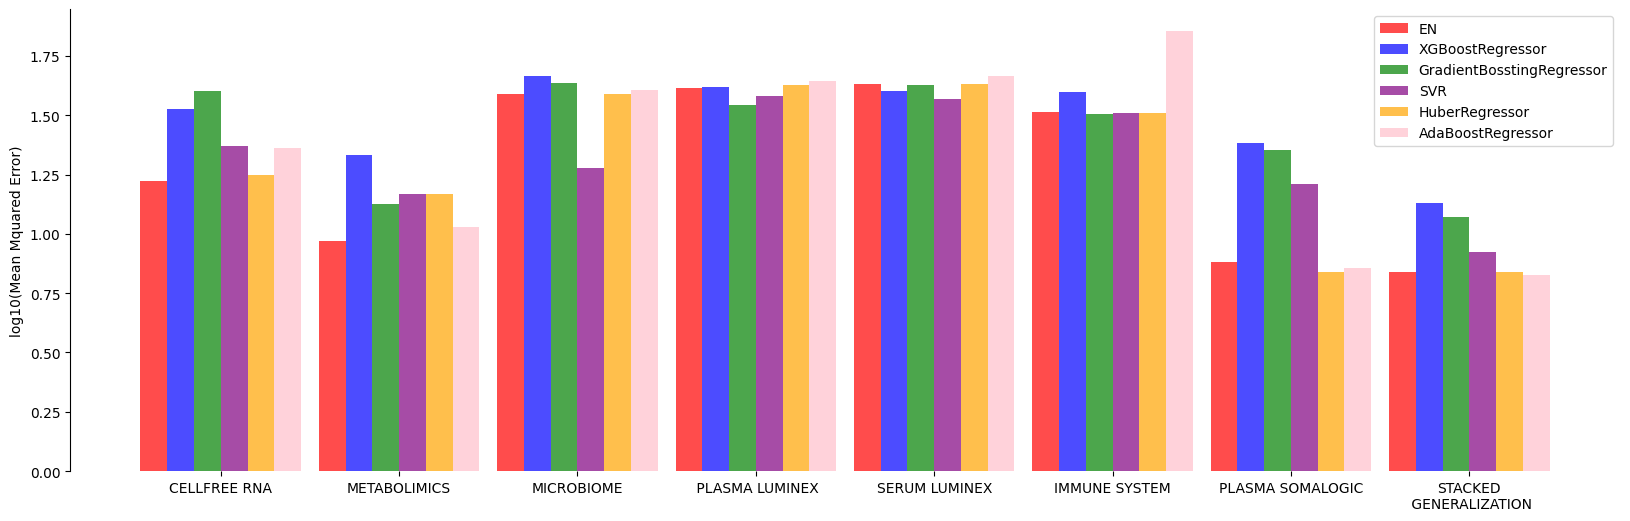

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for the 6 groups of bars (replace with your actual data)
group_names = ['EN', 'XGBoostRegressor', 'GradientBosstingRegressor', 'SVR', 'HuberRegressor', 'AdaBoostRegressor']
bar_names = ['CELLFREE RNA', 'METABOLIMICS', 'MICROBIOME', ' PLASMA LUMINEX', 'SERUM LUMINEX', 'IMMUNE SYSTEM', 'PLASMA SOMALOGIC','STACKED\n GENERALIZATION']

# Generate random data for the bars
data = data_array.T

# Define custom colors for each bar
custom_colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan']

# Set the width of each bar
bar_width = 0.15

# Create x-axis positions for each group of bars
x = np.arange(len(bar_names))

# Set a custom figure size
plt.figure(figsize=(20, 6))

# Create the bar plot for each group of bars with custom colors
for i, group_name in enumerate(group_names):
    plt.bar(x + i * bar_width, data[i], bar_width, label=group_name, alpha=0.7, color=custom_colors[i])

# Customize the x-axis labels
plt.xticks(x + (len(group_names) / 2 - 0.5) * bar_width, bar_names)

# Add labels, title, and legend
plt.ylabel('log10(Mean Mquared Error)')
# plt.title('Bar Plot with 6 Groups of Bars, Each Containing 7 Bars')
plt.legend()
# plt.yscale("log")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Show the plot
plt.show()
